[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Multivariate Kalman Filters

In [1]:
#format the book
%matplotlib inline
from __future__ import division, print_function
from book_format import load_style, set_figsize, figsize
load_style()

## Introduction

The techniques in the last chapter are very powerful, but they only work in one dimension. The gaussians represent a mean and variance that are scalars - real numbers. They provide no way to represent multidimensional data, such as the position of a dog in a field. You may retort that you could use two Kalman filters for that case, one tracks the x coordinate and the other tracks the y coordinate. That does work in some cases, but put that thought aside, because soon you will see some enormous benefits to implementing the multidimensional case.

In this chapter I am purposefully glossing over many aspects of the mathematics behind Kalman filters. If you are familiar with the topic you will read statements that you disagree with because they contain simplifications that do not necessarily hold in more general cases. If you are not familiar with the topic, expect some paragraphs to be somewhat 'magical' - it will not be clear how I derived a certain result. I prefer that you develop an intuition for how these filters work through several worked examples. If I started by presenting a rigorous mathematical formulation you would be left scratching your head about what all these terms mean and how you might apply them to your problem. In later chapters I will provide a more rigorous mathematical foundation, and at that time I will have to either correct approximations that I made in this chapter or provide additional information that I did not cover here. 

To make this possible we will restrict ourselves to a subset of problems which we can describe with Newton's equations of motion. In the literature these filters are called 
*discretized continuous-time kinematic filters*. In the next chapter we will develop the math required for solving any kind of dynamic system. 


In this chapter we are dealing with a simpler form that we can discuss in terms of Newton's equations of motion: given a constant velocity v we can compute distance exactly with:

$$ x = vt + x_0$$

If we instead assume constant acceleration we get

$$ x = \frac{1}{2}at^2 + v_0 t + x_0$$

And if we assume constant jerk we get

$$ x = \frac{1}{6}jt^3 +  \frac{1}{2}a_0 t^2 + v_0 t + x_0$$

As a reminder, we can generate these equations using basic calculus. Given a constant velocity v we can compute the distance traveled over time with the equation

$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x - x_0 &= vt - 0\\
x &= vt + x_0\end{aligned}$$

## Multivariate Normal Distributions

What might a *multivariate normal distribution* look like? In this context, multivariate just means multiple variables. Our goal is to be able to represent a normal distribution across multiple dimensions. Consider the 2 dimensional case. Let's say we believe that $x = 2$ and $y = 17$ This might be the *x* and *y* coordinates for the position of our dog, or the temperature and wind speed at our weather station, it doesn't really matter. We can see that for $N$ dimensions, we need $N$ means, like so:

$$
\mu = \begin{bmatrix}{\mu}_1\\{\mu}_2\\ \vdots \\{\mu}_n\end{bmatrix}
$$

Therefore for this example we would have

$$
\mu = \begin{bmatrix}2\\17\end{bmatrix} 
$$

The next step is representing our variances. At first blush we might think we would also need N variances for N dimensions. We might want to say the variance for x is 10 and the variance for y is 4, like so. 

$$\sigma^2 = \begin{bmatrix}10\\4\end{bmatrix}$$ 

This is incorrect because it does not consider the more general case. For example, suppose we were tracking house prices vs total $m^2$ of the floor plan. These numbers are *correlated*. It is not an exact correlation, but in general houses in the same neighborhood are more expensive if they have a larger floor plan. We want a way to express not only what we think the variance is in the price and the $m^2$, but also the degree to which they are correlated. It turns out that we use the following matrix to denote *covariances* with multivariate normal distributions. You might guess, correctly, that *covariance* is short for *correlated variances*.

$$
\Sigma = \begin{bmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{bmatrix}
$$

If you haven't seen this before it is probably a bit confusing at the moment. Rather than explain the math right now, we will take our usual tactic of building our intuition first with various physical models. At this point, note that the diagonal contains the variance for each state variable, and that all off-diagonal elements (covariances) are represent how much the $i$th (row) and $j$th (column) state variable are linearly correlated to each other. In other words, it is a measure for how much they change together. No correlation will have a covariance of 0. So, for example, if the variance for x is 10, the variance for y is 4, and there is no linear correlation between x and y, then we would say

$$\Sigma = \begin{bmatrix}10&0\\0&4\end{bmatrix}$$

If there was a small amount of correlation between x and y we might have

$$\Sigma = \begin{bmatrix}10&1.2\\1.2&4\end{bmatrix}$$

where 1.2 is the covariance between x and y. Note that this is always symmetric - the covariance between x and y is always equal to the covariance between y and x. That is, $\sigma_{xy}=\sigma_{yx}$ for any x and y.

Now, without explanation, here is the full equation for the multivariate normal distribution in $n$ dimensions.

$$\mathcal{N}(\mu,\,\Sigma) = (2\pi)^{-\frac{n}{2}}|\Sigma|^{-\frac{1}{2}}\, e^{ -\frac{1}{2}(\mathbf{x}-\mu)^\mathsf{T}\Sigma^{-1}(\mathbf{x}-\mu) }$$

I urge you to not try to remember this function. We will program it in a Python function and then call it when we need to compute a specific value. However, if you look at it briefly you will note that it looks quite similar to the *univariate normal distribution*  except it uses matrices instead of scalar values, and the root of $\pi$ is scaled by $n$. Here is the *univariate* equation for reference:

$$ 
f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} e^{{-\frac{1}{2}}{(x-\mu)^2}/\sigma^2 }
$$

If you are reasonably well-versed in linear algebra this equation should look quite manageable; if not, don't worry! Let's just plot it and see what it looks like.

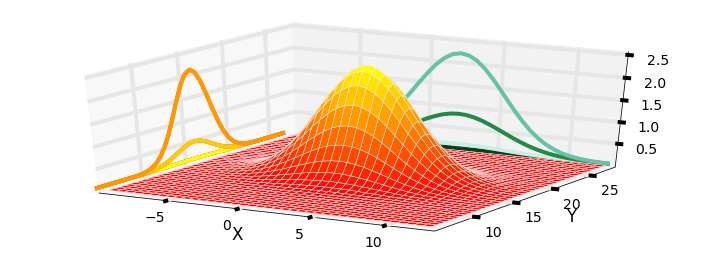

In [2]:
import mkf_internal
import numpy as np
mkf_internal.plot_3d_covariance((2, 17), np.array([[10., 0], [0, 4.]]))

Here we have plotted a two dimensional multivariate Gaussian with a mean of $\mu=[\begin{smallmatrix}2\\17\end{smallmatrix}]$ and a covariance of $\Sigma=[\begin{smallmatrix}10&0\\0&4\end{smallmatrix}]$. The three dimensional shape shows the probability of for any value of (x,y) in the z-axis. I have projected just the variance for x and y onto the walls of the chart - you can see that they take on the normal Gaussian bell curve shape. You can also see that, as we might hope, that the curve for x is wider than the curve for y, which is explained by $\sigma_x^2=10$ and $\sigma_y^2=4$. Also, the highest point of the curve is centered over (2,17), the means for x and y. I hope this demystifies the equation for you. Any multivariate Gaussian will create this sort of shape. If we think of this as a the Gaussian for our dog's position in a two dimensional field, the z-value at each point of (x,y) is the probability density for the dog being at that position. So, he has the highest probability of being near (2,17), a modest probability of being near (5,14), and a very low probability of being near (10,10).

We will discuss the mathematical description of covariances in the Kalman Filter math chapter. For this chapter we just need to understand the following.

1. The diagonal of the matrix contains the variance for each variable. 

2. Each off-diagonal element contains $\sigma_{ij}$ - the covariance between *i* and *j*. This tells us how much linear correlation there is between the two variables. 0 means no correlation, and as the number gets higher the correlation gets greater.

3. $\sigma_{ij} = \sigma_{ji}$

4. The covariance between x and itself is just the variance of x: $\sigma_{xx} = \sigma_x^2$.

5. This chart only shows a 2 dimensional Gaussian, but the equation works for any number of dimensions >= 1. It's kind of hard to show a chart for the higher dimensions.

I have programmed the multivariate Gaussian equation and saved it in the file `stats.py` with the function name `multivariate_gaussian`. I am not showing the code here because I have taken advantage of the linear algebra solving apparatus of NumPy to efficiently compute a solution - the code does not correspond to the equation in a one to one manner. If you wish to view the code, I urge you to either load it in an editor, or load it into this worksheet by putting `%load -s multivariate_gaussian stats.py` in the next cell and executing it with CTRL-enter. 

However, please note that the Kalman filter equations incorporate this computation automatically; you will not be using this function very often in this book, so I would not spend a lot of time mastering this function unless it interests you.

>As of version 0.14 scipy.stats has implemented the multivariate normal equation with the function `multivariate_normal()`. It implements a 'frozen' form where you set the mean and covariance once, and then calculate the probability for any number of values for x over any arbitrary number of calls. This is much more efficient then recomputing everything in each call. So, if you have version 0.14 or later you may want to substitute my function for the built in version. Use `scipy.version.version` to get the version number. I deliberately named my function `multivariate_gaussian()` to ensure it is never confused with the built in version. I will say that for a single call, where the frozen variables do not matter, mine consistently runs faster as measured by the `timeit` function.

> The <a href="http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html">tutorial</a>[1] for the `scipy.stats` module explains 'freezing' distributions and other very useful features. As of this date, it includes an example of using the multivariate_normal function, which does work a bit differently from my function.

In [3]:
from stats import gaussian, multivariate_gaussian

Let's use it to compute a few values just to make sure we know how to call and use the function, and then move on to more interesting things.

First, let's find the probability density for our dog being at (2.5, 7.3) if we believe he is at (2, 7) with a variance of 8 for $x$ and a variance of 4 for $y$.

Start by setting $x$ to (2.5, 7.3):

In [4]:
x = [2.5, 7.3]

Next, we set the mean of our belief:

In [5]:
mu = [2.0, 7.0]

Finally, we have to define our covariance matrix. In the problem statement we did not mention any correlation between $x$ and $y$, and we will assume there is none. This makes sense; a dog can choose to independently wander in either the $x$ direction or $y$ direction without affecting the other. If there is no correlation between the values you just fill in the diagonal of the covariance matrix with the variances. I will use the seemingly arbitrary name $\textbf{P}$ for the covariance matrix. The Kalman filters use the name $\textbf{P}$ for this matrix, so I will introduce the terminology now to avoid explaining why I change the name later. 

In [6]:
P = [[8.,  0.], 
     [0., 4.]]

Now just call the function

In [7]:
print('{:.4}'.format(multivariate_gaussian(x, mu, P)))

0.02739


> Note that the function can accept lists, np.array, or np.matrix as arguments, or even scalars. Type `multivariate_gaussian?` in a cell and press CTRL-enter to get the help for this function. 

These numbers are not easy to interpret. Let's plot this in 3D, with the $z$ (up) coordinate being the probability distribution.

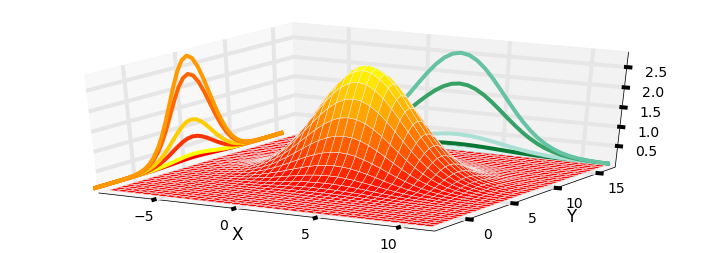

In [8]:
import mkf_internal
mkf_internal.plot_3d_covariance(mu, P)

The result is clearly a 3D bell shaped curve. We can see that the Gaussian is centered around (2,7), and that the probability density quickly drops away in all directions. On the sides of the plot I have drawn the Gaussians for $x$ in greens and for $y$ in orange.

Let's look at this in a slightly different way. Instead of plotting a surface showing the probability distribution I will just generate 1,000 points with the distribution of $[\begin{smallmatrix}8&0\\0&4\end{smallmatrix}]$.

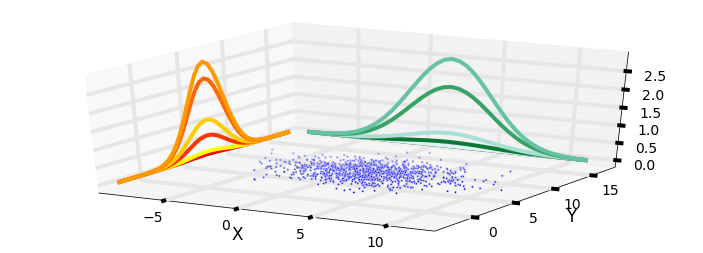

In [9]:
mkf_internal.plot_3d_sampled_covariance(mu, P)

We can think of the sampled points as being possible locations for our dog given those particular mean and covariances. The contours on the side show the variance in the points for $x$ and $y$ only.

As beautiful as this is, it is perhaps a bit hard to get useful information. For example, it is not easy to tell if $x$ and $y$ both have the same variance or not. So for most of the rest of this book we will display multidimensional Gaussian using contour plots. I will use some helper functions in `stats.py` to plot them. If you are interested in linear algebra go ahead and look at the code used to produce these contours, otherwise feel free to ignore it. 

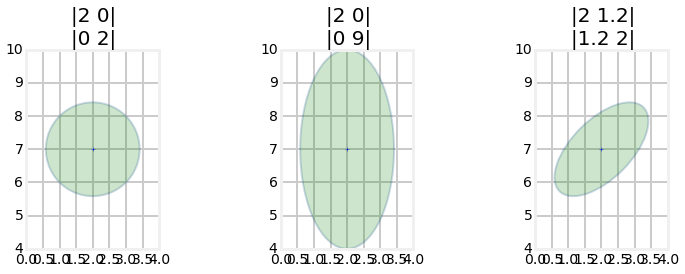

In [10]:
import matplotlib.pyplot as plt
import stats

set_figsize(y=4)

P = np.array([[2, 0], [0, 2]])
plt.subplot(131)
stats.plot_covariance_ellipse((2, 7), cov=P, facecolor='g', alpha=0.2, 
                              title='|2 0|\n|0 2|', axis_equal=False)
plt.ylim((4, 10))
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(132)
P = np.array([[2, 0], [0, 9]])
plt.ylim((4, 10))
plt.gca().set_aspect('equal', adjustable='box')
stats.plot_covariance_ellipse((2, 7), P, facecolor='g', alpha=0.2, 
                              axis_equal=False, title='|2 0|\n|0 9|')

plt.subplot(133)
P = np.array([[2, 1.2], [1.2, 2]])
plt.ylim((4, 10))
plt.gca().set_aspect('equal', adjustable='box')
stats.plot_covariance_ellipse((2, 7), P, facecolor='g', alpha=0.2, 
                              axis_equal=False, 
                              title='|2 1.2|\n|1.2 2|')

plt.tight_layout()
plt.show()

And for those of you viewing this online or in IPython Notebook on your computer, here is an animation.
<img src='animations/multivariate_ellipse.gif'>

From a mathematical perspective these display the values that the multivariate Gaussian takes for a specific standard deviation. This is like taking a horizontal slice out of the 3D plot. By default it displays one standard deviation, but you can use the `variance` parameter to control what is displayed. For example, `variance=3**2` would display the 3rd standard deviation, and `variance=[1,4,9]` would display the 1st, 2nd, and 3rd standard deviations as in the chart below. This takes 3 different horizontal slices of the multivariate Gaussian chart and displays them in 2D.

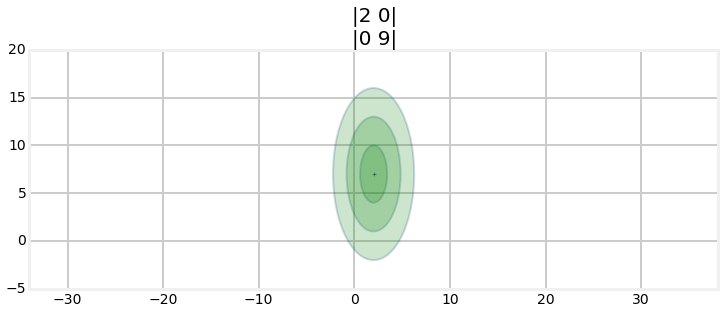

In [11]:
P = np.array([[2, 0], [0, 9]])

stats.plot_covariance_ellipse((2, 7), P, facecolor='g', alpha=0.2, 
                              variance=[1, 2**2, 3**2],
                              axis_equal=True, title='|2 0|\n|0 9|')

Thinking about the physical interpretation of these plots clarifies their meaning. The first plot uses the mean and covariance matrices of
$$
\begin{aligned}
\mathbf{\mu} &= \begin{bmatrix}2\\7\end{bmatrix} \\
\Sigma &= \begin{bmatrix}2&0\\0&2\end{bmatrix}
\end{aligned}
$$ 

Let this be our current belief about the position of our dog in a field. In other words, we believe that he is positioned at (2,7) with a variance of $\sigma^2=2$ for both x and y. The contour plot shows where we believe the dog is located with the '+' in the center of the ellipse. The ellipse shows the boundary for the $1\sigma$ probability, where $1\sigma$ is one *standard deviation*. In other words, for this Gaussian 68% of the data will fall within this ellipse. Recall from the Gaussians chapter the the 68-95-99.7 rule - 68% of all values will fall within 1 standard deviation ($1\sigma$), 95% within $2\sigma$, and 99.7% within $3\sigma$. The dog could be at (356443,58483), but the chances for values that far away from the mean are infinitesimally small.

An equivalent way of thinking about this is the circle/ellipse shows us the amount of error in our belief. A tiny circle would indicate that we have a very small error, and a very large circle indicates a lot of error in our belief. We will use this throughout the rest of the book to display and evaluate the accuracy of our filters at any point in time. 

The second plot uses the mean and covariance matrices of

$$
\begin{aligned}
\mu &=\begin{bmatrix}2\\7\end{bmatrix} \\
\Sigma &= \begin{bmatrix}2&0\\0&9\end{bmatrix}
\end{aligned}
$$

This time we use a different variance for $x$ (2) vs $y$ (9). The result is an ellipse. When we look at it we can immediately tell that we have a lot more uncertainty in the $y$ value vs the $x$ value. Our belief that the value is (2,7) is the same in both cases, but errors are different. In this case the standard deviation in $x$ is $\sigma_x = \sqrt{2}=1.414$ and the standard deviation for $y$ is $\sigma_y = \sqrt{9}=3$. This sort of thing happens naturally as we track objects in the world - one sensor has a better view of the object, or is closer, than another sensor, and so we end up with different error rates in the different axis.

The third plot uses the mean and covariance matrices of:
$$
\begin{aligned}
\mu &=\begin{bmatrix}2\\7\end{bmatrix} \\
\Sigma &= \begin{bmatrix}2&1.2\\1.2&2\end{bmatrix}
\end{aligned}
$$

This is the first contour that has values in the off-diagonal elements of $cov$, and this is the first contour plot with a slanted ellipse. This is not a coincidence. The two facts are telling use the same thing. A slanted ellipse tells us that the $x$ and $y$ values are somehow **correlated**. We denote that in the covariance matrix with values off the diagonal. What does this mean in physical terms? Think of trying to park your car in a parking spot. You can not pull up beside the spot and then move sideways into the space because most cars cannot go purely sideways. $x$ and $y$ are not independent. This is a consequence of the steering system in a car. When your tires are turned the car rotates around its rear axle while moving forward. Or think of a horse attached to a pivoting exercise bar in a corral. The horse can only walk in circles, he cannot vary $x$ and $y$ independently, which means he cannot walk straight forward to to the side. If $x$ changes, $y$ must also change in a defined way. 

So when we see this ellipse we know that $x$ and $y$ are correlated, and that the correlation is "strong". The size of the ellipse shows how much error we have in each axis, and the slant shows how strongly correlated the values are.

Let's look at this in a graph and then reason about it. Let's assume that we have a covariance for the position of our dog, which we believe is at coordinate (5, 10) meters. If the standard deviation in x and y is each 2 meters, but they are strongly correlated, our covariance contour would look like this.

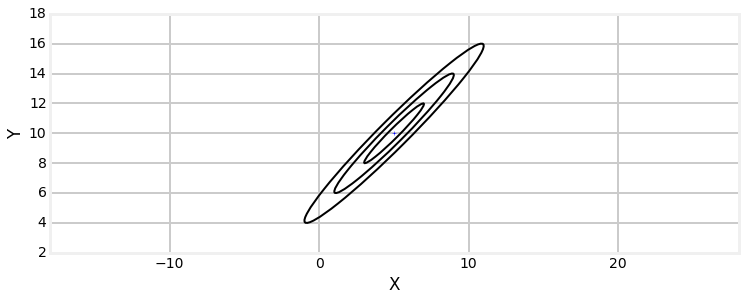

In [12]:
P = np.array([[4, 3.9], [3.9, 4]])
stats.plot_covariance_ellipse((5, 10), P, edgecolor='k', 
                              variance=[1, 2**2, 3**2])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Now suppose I were to tell you that the actual position of the dog in the *x* dimension is 7.5, what can we infer about his position in *y*? The position is extremely likely to lie within the 3$\sigma$ covariance, as in the chart below. We can *infer* the like position in *y* based on the covariance matrix because there is a correlation between *x* and *y*.

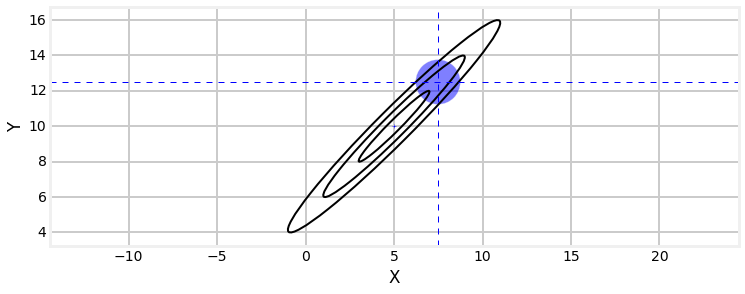

In [13]:
P = np.array([[4, 3.9], [3.9, 4]])
stats.plot_covariance_ellipse((5, 10), P, edgecolor='k', 
                              variance=[1, 2**2, 3**2])
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().autoscale(tight=True)
plt.axvline(7.5, ls='--', lw=1)
plt.axhline(12.5, ls='--', lw=1)
plt.scatter(7.5, 12.5, s=2000, alpha=0.5)
plt.plot()
plt.show()

A word about **correlation** and **independence**. If variables are **independent** they can vary separately. If you walk in an open field, you can move in the $x$ direction (east-west), the $y$ direction(north-south), or any combination thereof. Independent variables are always also **uncorrelated**. Except in special cases, the reverse does not hold true. Variables can be uncorrelated, but dependent. For example, consider the pair$(x,y)$ where $y=x^2$. Correlation is a linear measurement, so $x$ and $y$ are uncorrelated. However, they are obviously dependent on each other. 

## Computing Means and Covariances

You will not need to do this by hand for the rest of the book, but it is important to understand the computations behind these values. It only takes a few minutes to learn.

### Computing the Mean
So let's start with 3 variables: $a, b, c$. Let's say we have two values for each: $a = [1, 3]$, $b = [8, 7]$, and $c = [3,7]$. Another, equivalent way of writing this is that you will sometimes see is

$$\mathbf{x} = \begin{bmatrix}a\\b\\c\end{bmatrix} = \begin{bmatrix}1 & 3\\8&7\\3&7\end{bmatrix}$$

You will not see that often in the Kalman filter literature, so I will adopt the alternative notation of using a subscript to indicate the $i^{th}$ value for $\mathbf{x}$

$$\mathbf{x}_0 = \begin{bmatrix}1 \\8\\3\end{bmatrix},\ \  \mathbf{x}_1 = \begin{bmatrix}3\\7\\7\end{bmatrix}$$

We compute the mean just as for the univariate case, which we presented in the *Gaussians* chapter. Sum the values and divide by the number of values. Formally

$$ \mu_x = \frac{1}{n}\sum^n_{i=1} x_i$$

Therefore we can write:

$$\begin{aligned}
\mu_a &= \frac{1+3}{2} = 2 \\
\mu_b &= \frac{8+7}{2} = 7.5 \\
\mu_c &= \frac{3+7}{2} = 5 
\end{aligned}$$

Which I can express in our shorthand matrix notation as

$$\mu_x = \begin{bmatrix}2\\7.5\\5\end{bmatrix}$$

### Expected Value

I could just give you the formula for the covariance but it will make more sense if you see how it is derived. To do that we first need to talked about *expected value* of a random variable. The expected value is just the value we expect, on average, for the variable. 

The *expected value* of a random variable is just the average value it would have if we took an infinite number of samples of it and then averaged those samples together. Let's say we have $x=[1,3,5]$ and each value is equally probable. What would we *expect* $x$ to have, on average?

It would just be the average of 1, 3, and 5, of course, which is 3. That should make sense; we would expect equal numbers of 1, 3, and 5 to occur, so $(1+3+5)/3=3$ is clearly the average of that infinite series of samples.

Now suppose that each value has a different probability of happening. Say 1 has an 80% chance of occurring, 3 has an 15% chance, and 5 has only a 5% chance. In this case we compute the expected value by multiplying each value of $x$ by the percent chance of it occurring, and summing the result. So for this case we could compute

$$E[x] = (1)(0.8) + (3)(0.15) + (5)(0.05) = 1.5$$

Here I have introduced the standard notation $E[x]$ for the expected value of $x$.

We can formalize this by letting $x_i$ be the $i^{th}$ value of $x$, and $p_i$ be the probability of its occurrence. This gives us

$$E[X] = \sum_{i=1}^n p_ix_i$$

The value 1.5 for $x$ makes intuitive sense because x is far more like to be 1 than 3 or 5, and 3 is more likely than 5 as well.

It is probably worth me pointing out now that if $x$ is continuous we substitute the sum for an integral, like so

$$E[X] = \int_{-\infty}^\infty xf(x)$$

where $f(x)$ is the probability distribution function of $x$. We won't be using this equation yet, but we will be using it in the next chapter.

### Computing the Covariance


Now we are prepared to compute the covariance matrix. The *covariance* measures how much two random variables move in the same direction, and is defined as

$$ COV(x,y) = \frac{1}{N}\sum_{i=1}^N (x_i - \mu_x)(y_i - \mu_y)$$

If we compare this to the formula for the variance of a single variable we can see where this definition came from.

$$\sigma^2 = \frac{1}{N}\sum_{i=1}^N(x_i - \mu)^2$$

And indeed, the covariance of a variable with itself is just the variance of the variable, which we can trivially prove with

$$\begin{aligned}
COV(x,x) &= \frac{1}{N}\sum_{i=1}^N (x_i - \mu_x)(x_i - \mu_x) \\
&= \frac{1}{N}\sum_{i=1}^N (x_i - \mu_x)^2 \\
&= VAR(x)
\end{aligned}$$


Let's build some familiarity with this by calculating the covariance for $\mathbf{x}$ above. 

$$\mathbf{x}_0 = \begin{bmatrix}1 \\8\\3\end{bmatrix},\ \  \mathbf{x}_1 = \begin{bmatrix}3\\7\\7\end{bmatrix}$$

We already know the mean is

$$\mu_x = \begin{bmatrix}2\\7.5\\5\end{bmatrix}$$

Recall that we named the three variables as $a, b, c$. Let's start by computing the variance of $a$.

$$
\begin{aligned}
VAR(a) &= \frac{1}{2}[(1-2)^2 + (3-2)^2] \\
&= \frac{1}{2}[1+1] \\
&= 1\end{aligned}$$


Using similar math we can compute that $VAR(a) = 0.25$ and $VAR(c)=4$. This allows us to fill in the covariance matrix with

$$\Sigma = \begin{bmatrix}1 & & \\ & 0.25 & \\ &&4\end{bmatrix}$$

Now we can compute the covariance of a and b.

$$
\begin{aligned}
COV(a,b) &= \frac{1}{2}[(1-2)(8-7.5) + (3-2)(7-7.5)] \\
&= \frac{1}{2}[(-1)(.5)+  (1)(-.5)] \\
&= -0.5\end{aligned}$$

We can fill in the $a^{th}$ row and $b^{th}$ column  in the covariance matrix with this value:

$$\Sigma = \begin{bmatrix}1 & & \\ -0.5 & 0.25 & \\ &&4\end{bmatrix}$$

We already talked about the symmetry of the covariance matrix; $\sigma_{ab}=\sigma_{ba}$. We see now why this is true from the equation for the covariance.

$$\begin{aligned} COV(x,y) &= \frac{1}{N}\sum_{i=1}^N (x_i - \mu_x)(y_i - \mu_y) \\
&= \frac{1}{N}\sum_{i=1}^N (y_i - \mu_y)(x_i - \mu_x) \\
&= COV(y,x)\end{aligned}$$

This gives the covariance matrix

$$\Sigma = \begin{bmatrix}1 &-0.5 & \\ -0.5 & 0.25 & \\ &&4\end{bmatrix}$$.

The arithmetic is a bit tedious, so let's just use NumPy's `cov()` function to compute the entire covariance matrix. To compute the covariance in accordance with the equations above you will need to set the parameter `bias=1`.  The meaning of that parameter is not important to this book. If you are interested, wikipedia has a good article on it here http://en.wikipedia.org/wiki/Bias_of_an_estimator.

In [14]:
x = np.array([[1, 3], [8, 7], [3, 7]])
print(np.cov(x, bias=1))

[[ 1.   -0.5   2.  ]
 [-0.5   0.25 -1.  ]
 [ 2.   -1.    4.  ]]


We said above that "the *covariance* measures how much two random variables move in the same direction", so let's see what that means in practice. We will do this with two variables so that we can plot the covariance matrix. If we start with the value $x_0 = (1, 2)$ we can create subsequent sames that vary in the same direction with $x_1 = (2, 4)$, $x_2=(3,6)$, and $x_3=(4,8). I don't feel like computing this by hand, so we will use NumPy to compute the covariance.

[[ 1.25  2.5 ]
 [ 2.5   5.  ]]


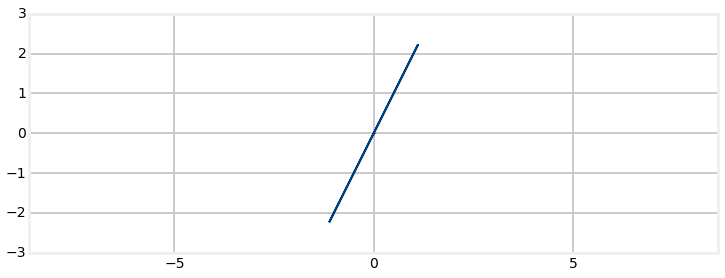

In [15]:
x = np.array([[1, 2, 3, 4], [2, 4, 6, 8]])
cov = np.cov(x, bias=1)
stats.plot_covariance_ellipse([0, 0], cov)
print(cov)

The values for $x$ are perfectly correlated, and the result is a covariance ellipse with zero width. We can see this by making the values not slightly uncorrelated.

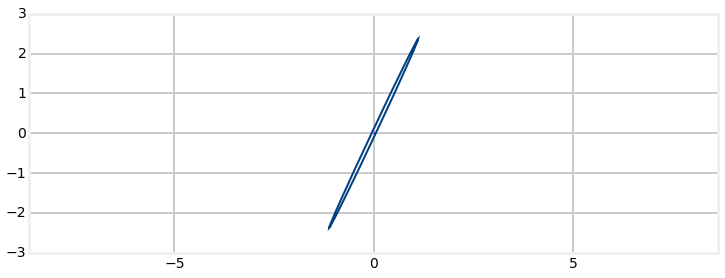

In [16]:
x = np.array([[1, 2, 3, 4], [2, 4, 6, 8.4]])
stats.plot_covariance_ellipse([0, 0], np.cov(x, bias=1))

Now lets make the second value go away from the first.

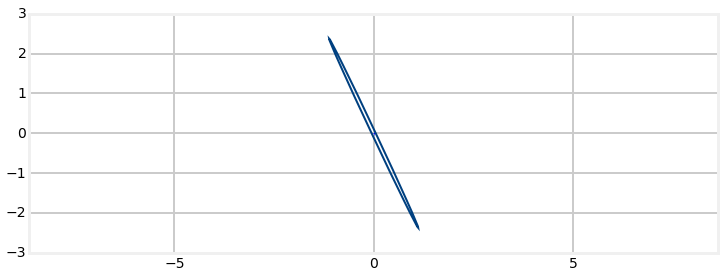

In [17]:
x = np.array([[1, 2, 3, 4], [-2, -4, -6, -8.4]])
stats.plot_covariance_ellipse([0, 0], np.cov(x, bias=1))

As we would hope, the covariance matrix is tilted in the opposite direction, indicating that the variables are inversely correlated. That is, as one gets larger, the other becomes smaller.

## Multiplying Multidimensional Gaussians

In the previous chapter we incorporated an uncertain measurement with an uncertain estimate by multiplying their Gaussians together. The result was another Gaussian with a smaller variance. If two piece of uncertain information corroborate each other we should be more certain in our conclusion. The graphs look like this:

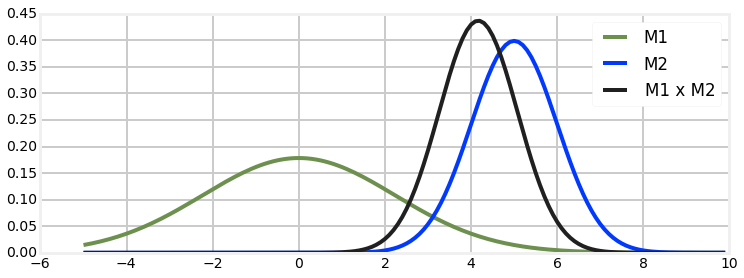

In [18]:
import stats
xs = np.arange(-5, 10, 0.1)

mean1, var1 = 0, 5
mean2, var2 = 5, 1
mean, var = stats.mul(mean1, var1, mean2, var2)

ys = [stats.gaussian(x, mean1, var1) for x in xs]
plt.plot(xs, ys, label='M1')

ys = [stats.gaussian(x, mean2, var2) for x in xs]
plt.plot(xs, ys, label='M2')

ys = [stats.gaussian(x, mean, var) for x in xs]
plt.plot(xs, ys, label='M1 x M2')
plt.legend()
plt.show()

The combination of measurement 1 and 2 yields more certainty, so the new Gaussian is taller and narrower - the variance became smaller. The same thing happens in multiple dimensions with multivariate Gaussians.

Here are the equations for multiplying multivariate Gaussians. You will not need to remember these equations, as they are backed into the Kalman filter equations that will be presented shortly. This computation is also available in FilterPy using the `multivariate_multiply()` method, which you can import from `filterpy.common`. 

$$\begin{aligned}
\mu &= \Sigma_2(\Sigma_1 + \Sigma_2)^{-1}\mu_1 + \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}\mu_2 \\
\Sigma &= \Sigma_1(\Sigma_1+\Sigma_2)^{-1}\Sigma_2
\end{aligned}$$

To give you some intuition about this, recall the equations for multiplying univariate Gaussians:

$$\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}
\end{aligned}$$

This looks similar to the equations for the multivariate equations. This will be more obvious if you recognize that matrix inversion, denoted by the -1 power, is *like* division since $AA^{-1} =I$. I will rewrite the inversions as divisions - this is not a mathematically correct thing to do as the order of operations becomes ambiguous (matrix multiplication is not commutative), but it does help us see what is going on.



$$\begin{aligned}\mu &\approx \frac{\Sigma_2\mu_1 + \Sigma_1\mu_2}{\Sigma_1 + \Sigma_2} \\
\Sigma &\approx \frac{\Sigma_1\Sigma_2}{(\Sigma_1+\Sigma_2)}
\end{aligned}$$

In this form we can see that these equations are just the linear algebra form of the univariate equations.

Now Let's explore multivariate Gaussians in terms of a concrete example. Suppose that we are tracking an aircraft with a couple of radar systems. I will ignore altitude as this is easier to graph in two dimensions. Radars give us the range and bearing to a target. We start out being uncertain about the position of the aircraft, so the covariance, which is just our uncertainty about the position, might look like this. 

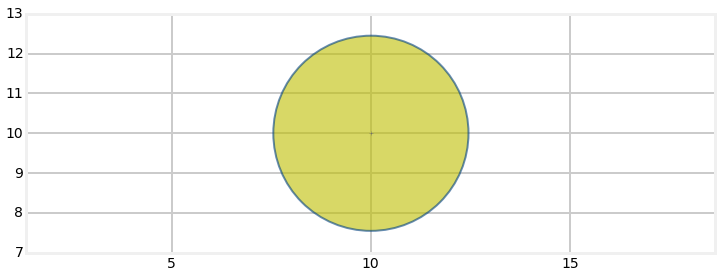

In [19]:
P0 = np.array([[6, 0], [0, 6]])
stats.plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.6)

Now suppose that there is a radar to the lower right of the aircraft. Further suppose that the radar is very accurate in the bearing measurement, but not very accurate at the range. That covariance, which is just the uncertainty in the reading might look like this (plotted in blue):

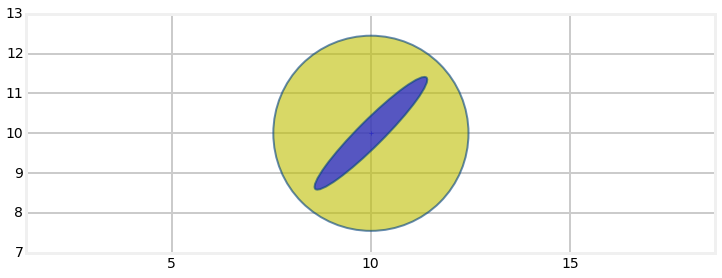

In [20]:
P1 = np.array([[2, 1.9], [1.9, 2]])
stats.plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.6)
stats.plot_covariance_ellipse((10, 10), P1, facecolor='b', alpha=0.6)

To combine the information we multiply the two Gaussians together. Let's see the result of that. I will use FilterPy's `multivariate_multiply` method to perform the multiplication.

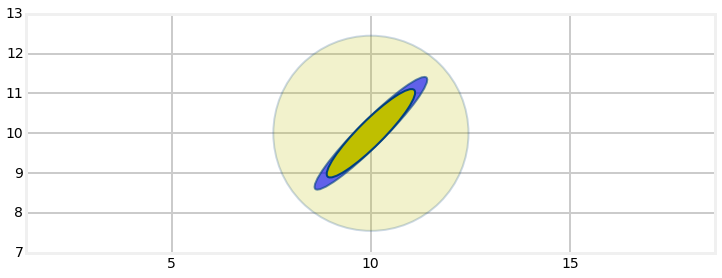

In [21]:
from stats import multivariate_multiply

P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]

stats.plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.2)
stats.plot_covariance_ellipse((10, 10), P1, facecolor='b', alpha=0.6)
stats.plot_covariance_ellipse((10, 10), P2, facecolor='y')

Here I have plotted the original estimate it a very transparent yellow, the radar reading in blue, and the estimate generate by multiplying the two Gaussians together in yellow.

It retained the same shape and position as the radar measurement, but is smaller. We've seen this with the one dimensional Gaussians - multiplying two Gaussians makes the variance smaller because we are incorporating more information, hence we are less uncertain.  But the main point I want to make is that the covariance shape reflects the physical layout of the aircraft and the radar system.

Now lets say we get a measurement from a second radar bank, this one to the lower right, which I will plot in blue against the yellow covariance of our current belief. 

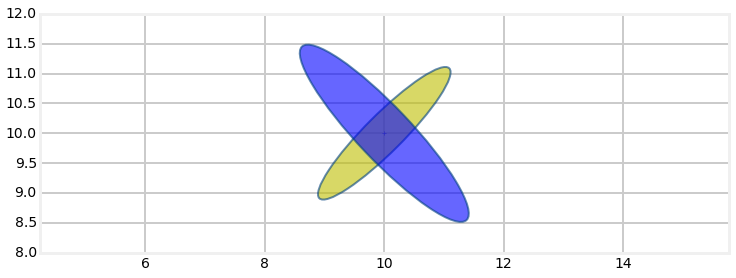

In [22]:
P3 = np.array([[2, -1.9], [-1.9, 2.2]])
stats.plot_covariance_ellipse((10, 10), P2, facecolor='y', alpha=0.6)
stats.plot_covariance_ellipse((10, 10), P3, facecolor='b', alpha=0.6)

Again, to incorporate this new information we will multiply the Gaussians together.

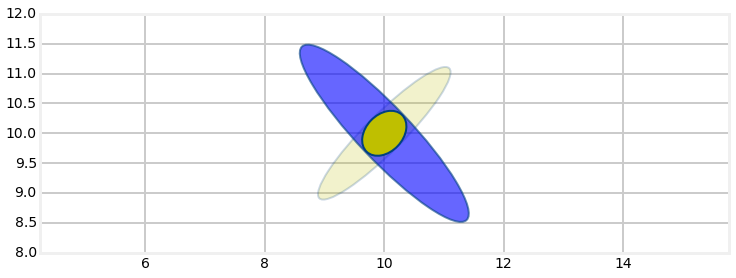

In [23]:
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]

stats.plot_covariance_ellipse((10, 10), P2, facecolor='y', alpha=0.2)
stats.plot_covariance_ellipse((10, 10), P3, facecolor='b', alpha=0.6)
stats.plot_covariance_ellipse((10, 10), P4, facecolor='y')

You can see how the multivariate Gaussian's shape reflects the geometry of the problem. The first radar system was at a 45 degree angle to the aircraft, and its error in the bearing measurement was much smaller than the error in the range. This resulted in a long and narrow covariance ellipse whose major axis was aligned with the angle to the radar system. The next radar system was also at a 45 degree angle, but to the right, so the two measurements were orthogonal to each other. This allowed us to *triangulate* on the aircraft, which resulted in a very accurate final estimate. We didn't explicitly write any code to perform triangulation; it was a natural outcome of multiplying the Gaussians of each measurement together.

To make sure you understand this, what would the Gaussian look like if we only had one radar station, and we receive several measurements from it over a short period of time? Clearly the Gaussian would remain elongated in the axis of the bearing angle. Without a second radar station no information would be provided to reduce the error on that axis, so it would remain quite large. As the aircraft moves the bearing will typically change by a small amount, so over time some of the error will be reduced, but it will never be reduced as much as a second radar station would provide.

To round this out lets quickly redo this example but with the first radar system in a different position. I will position it directly to the left of the aircraft. The only change I need to make is to the Gaussian for the measurement from the radar. I used

$$\Sigma = \begin{bmatrix}2&1.9\\1.9&2\end{bmatrix}$$

Why did this result in a 45 degree ellipse? Think about that before reading on. It was 45 degrees because the values in the diagonal were identical. So if x=10 then y=10, and so on. We can alter the angle by making the variance for x or y different, like so:

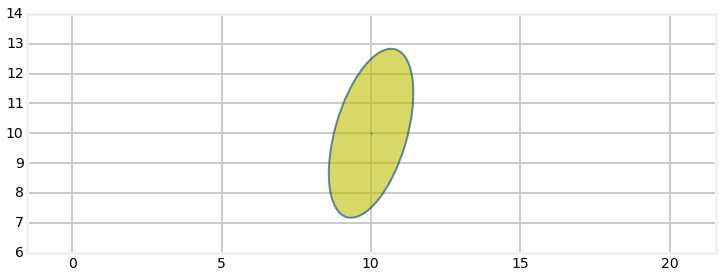

In [24]:
P1 = np.array([[2, 1.9], [1.9, 8]])
stats.plot_covariance_ellipse((10, 10), P1, facecolor='y', alpha=0.6)

The radar is to the left of the aircraft, so I can use a covariance of 
$$\Sigma = \begin{bmatrix}2&1.9\\1.9&2\end{bmatrix}$$
to model the measurement. In the next graph I plot the original estimate in a very light yellow, the radar measurement in blue, and the new estimate based on multiplying the two Gaussians together in yellow.

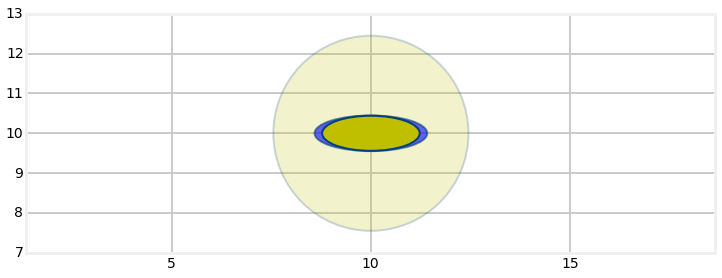

In [25]:
P1 = np.array([[2, 0], [0, .2]])

P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]

stats.plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.2)
stats.plot_covariance_ellipse((10, 10), P1, facecolor='b', alpha=0.6)
stats.plot_covariance_ellipse((10, 10), P2, facecolor='y')

Now we can incorporate the measurement from the second radar system, which we will leave in the same position as before.

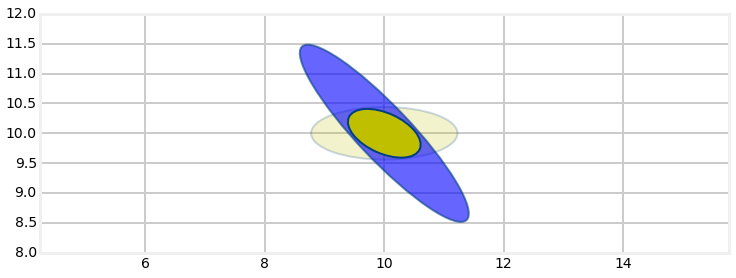

In [26]:
P3 = np.array([[2, -1.9], [-1.9, 2.2]])
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]

stats.plot_covariance_ellipse((10, 10), P2, facecolor='y', alpha=0.2)
stats.plot_covariance_ellipse((10, 10), P3, facecolor='b', alpha=0.6)
stats.plot_covariance_ellipse((10, 10), P4, facecolor='y')

In this result our final estimate is not as accurate as the previous example. Why is that? The two radar stations were no longer othogonal to the aircraft's position so the triangulation is not optimal. Imagine standing on the ground and trying to triangulate on an aircraft in the sky with a transit. If you took a measurement, moved the transit 5 meters and took a second measurement the tiny change in angle between the two measurements would result in a very poor measurement because a very small error in either measurement would give a wildly different result. Think of the measurements as two nearly parallel lines. Changing the angle between them slightly will move the intersection between the two by a large amount. If you were to take the measurements from positions 100km apart the lines might be nearly perpendicular to each other, in which case a small measurement error would result in a very small shift in the intersection point.

## Unobserved Variables

Let's say we are tracking an aircraft and we get the following data for the $x$ and $y$ coordinates at time $t$=1,2, and 3 seconds. What does your intuition tell you the value of $x$ will be at time $t$=4 seconds?

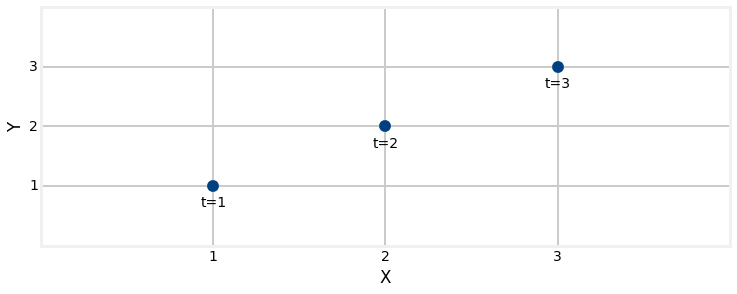

In [27]:
import mkf_internal
mkf_internal.show_position_chart()

It appears that the aircraft is flying in a straight line because we can draw a line between the three points, and we know that aircraft cannot turn on a dime. The most reasonable guess is that at $t$=4 the aircraft is at (4,4). I will depict that with a green arrow.

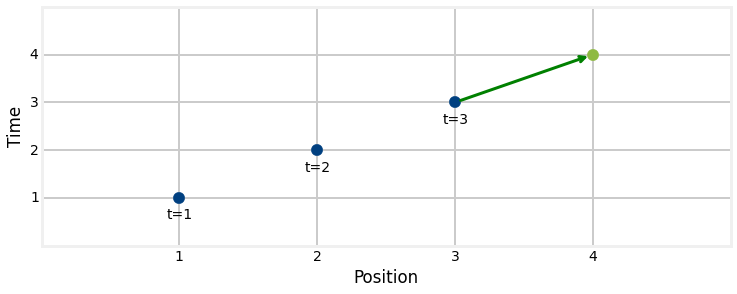

In [28]:
mkf_internal.show_position_prediction_chart()

You made this inference because you *inferred* a constant velocity for the airplane. The *reasonable* assumption is that the aircraft is moving one unit each in *x* and *y* per time step.

Think back to the g-h filter chapter when we were trying to improve the weight predictions of a noisy scale. We incorporated *weight gain* into the equations because it allowed us to make a better prediction of the weight the next day. The g-h filter uses the *g* parameter to scale the amount of significance given to the current weight measurement, and the *h* parameter scaled the amount of significance given to the weight gain.

We are going to do the same thing with our Kalman filter. After all, the Kalman filter is a form of a g-h filter (I have not proven this yet, but I will later on). In this case we are tracking an airplane, so instead of weight and weight gain we need to track position and velocity. Weight gain is the *derivative* of weight, and of course velocity is the derivative of position. Its hard to plot and understand the 3D chart that would be needed to plot *x* and *y* against time, so let's just do the 1D case.

So at time 1 we might be fairly certain about the position (x=0) but have no idea about the velocity. We can plot that with a covariance matrix like this. The narrow width expresses our relative certainty about position, and the tall height expresses our lack of knowledge about velocity.

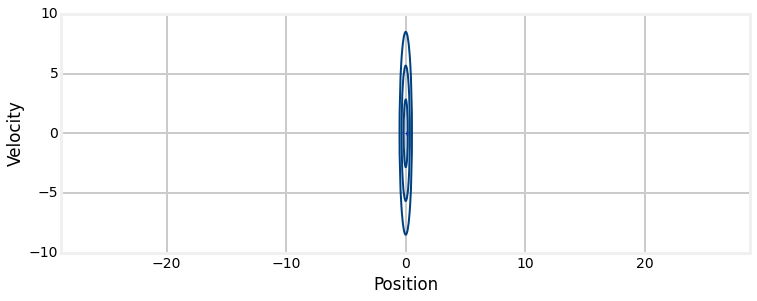

In [29]:
mkf_internal.show_x_error_chart(1)

Now after one second we get a position update of x=5. This implies that our velocity is roughly 5 m/s.

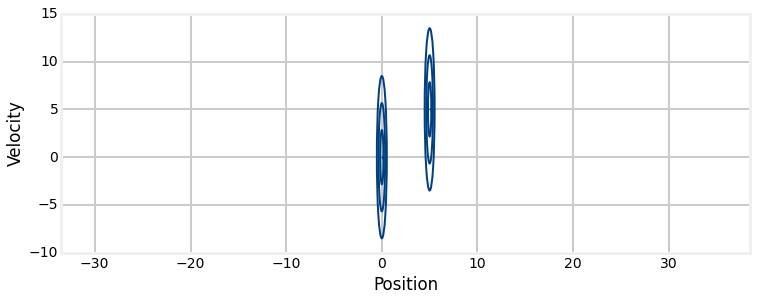

In [30]:
mkf_internal.show_x_error_chart(2)

But of course position and velocity are correlated. If the velocity is 5 m/s the position would be 5, but if the velocity was 10 m/s the position would be 10. So let's draw a velocity covariance matrix in red.

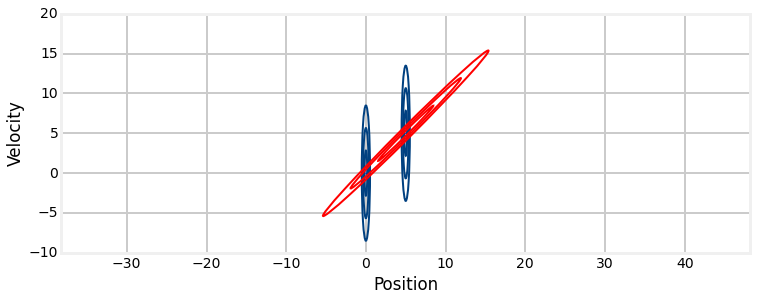

In [31]:
mkf_internal.show_x_error_chart(3)

This superposition of the two covariances is where all the magic happens. The only reasonable estimate at time t=1 (where position=5) is roughly the *intersection* between the two covariance matrices! More exactly, we can use the math from the last section and *multiply* the two covariances together. If we multiply the position covariance with the velocity covariance using the equations above, we get the result shown in the next chart.

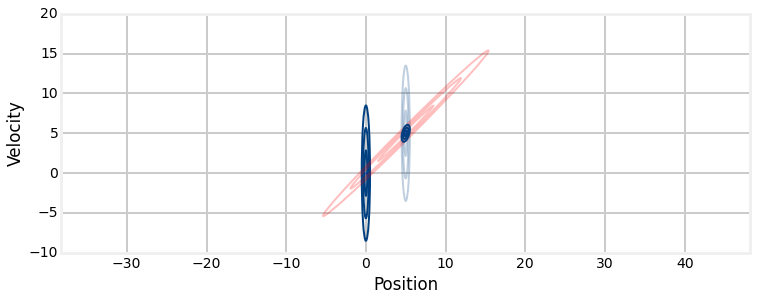

In [32]:
mkf_internal.show_x_error_chart(4)

We can see that the new covariance lies at the intersection of the position covariance and the velocity covariance. It is slightly tilted, showing that there is some correlation between the position and velocity. Far more importantly, it is far smaller than either the position or velocity covariances that make it up. In the previous chapter our variance would get smaller each time we performed an `update()` because the previous estimate's Gaussian was multiplied by the new measurement's Gaussian. The same thing is happening here. However, the amount that the covariance got smaller by is a huge amount in this chapter. This is because we are using two different kinds of information which are nevertheless correlated. Knowing the velocity approximately and the position approximately allows us to very quickly hone in on the correct answer. 

This is the **key point** in Kalman filters, so read carefully! Our sensor is only detecting the position of the aircraft (how doesn't matter). It does not have any kind of sensor that provides velocity to us. But based on the position estimates we can compute velocity. In Kalman filters we would call the velocity an *unobserved variable*. Unobserved means what it sounds like - there is no sensor that is measuring velocity directly. Since the velocity is based on the position, and the position has error, the velocity will have error as well. But as we can see the correlation between velocity and position means that we can very quickly eliminate most of that error.

What makes this possible? Imagine for a moment that we superimposed the velocity from a *different* airplane over the position graph. Clearly the two are not related, and there is no way that combining the two could possibly yield any additional information. In contrast, the velocity of the this airplane tells us something very important - the direction and speed of travel. So long as the aircraft does not alter its velocity the velocity allows us to predict where the next position is. After a relatively small amount of error in velocity the probability that it is a good match with the position is very small. Think about it - if you suddenly change direction your position is also going to change a lot. If the position measurement is not in the direction of the assumed velocity change it is very unlikely to be true. The two are correlated, so if the velocity changes so must the position, and in a predictable way. 

We are going to see this again and again in the rest of the book, so don't worry if this feels a bit magical to you. But it is important to understand that we are taking advantage of the fact that velocity and position are correlated coupled with the ability to infer velocity by looking at the distance and time between two measurement, to produce very accurate estimates after only a few observations. Please reread this section if you have any doubts. If you grasp this point the rest is straightforward. If you do not you will quickly find it impossible to reason about what you will learn in the rest of this chapter.

In summary we have taken advantage of the geometry and correlations of the system to produce a very accurate estimate. The math does not care whether we are working with two positions, or a position and a correlated velocity. If we can express our uncertainties as a multidimensional Gaussian we can then multiply our uncertainty in position with our uncertainty in velocity and get a much more accurate result, in exactly the same way we can multiply the uncertainty in two position estimates to get a more accurate result.

## Kalman Filter Algorithm

Now that we have that under our belts we can show how a multidimensional Kalman filter works. In the example above, we compute velocity from the previous position measurements using something called the *measurement function*. Then we predict the next position by using the current estimate and something called the *state transition function*. In our example above,

$$new\_position = old\_position + velocity*time$$ 

Next, we take the measurement from the sensor, and compare it to the prediction we just made. In a world with perfect sensors and perfect airplanes the prediction will always match the measured value. In the real world they will always be at least slightly different. We call the difference between the two the *residual*. Finally, we use something called the *Kalman gain* to update our estimate to be somewhere between the measured position and the predicted position. I will not describe how the gain is set, but suppose we had perfect confidence in our measurement - no error is possible. Then, clearly, we would set the gain so that 100% of the position came from the measurement, and 0% from the prediction. At the other extreme, if he have no confidence at all in the sensor (maybe it reported a hardware fault), we would set the gain so that 100% of the position came from the prediction, and 0% from the measurement. In normal cases, we will take a ratio of the two: maybe 53% of the measurement, and 47% of the prediction. The gain is updated on every cycle based on the variance of the variables (in a way yet to be explained). It should be clear that if the variance of the measurement is low, and the variance of the prediction is high we will favor the measurement, and vice versa. 

The chart shows a prior estimate of $x=2$ and a velocity $\dot{x}=1$. 

> We use the familiar dot notation $\dot{x}$ to denote the derivative of x with respect to time.

With the time step $\Delta t = 1$ we predict $x= 2+(1 \times 1) = 3$.

However, the new measurement is $z=2.3$, giving a residual $r=0.7$. Finally, the Kalman filter gain $K$ gives us a new estimate of $x=2.8$.

> We use the notation $z$ to denote a measurement. I will address notation in more detail later. It is an unfortunate reality that nearly every text on Kalman filtering uses different notation and variables - there is almost no agreement across texts. Be sure to read the introductory material very carefully to avoid being led astray.

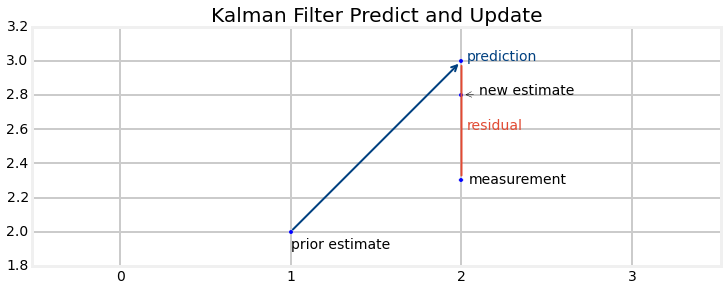

In [33]:
from mkf_internal import *
show_residual_chart()

## The Equations

The brilliance of the Kalman filter is taking the insights of the chapter up to this point and finding an optimal mathematical solution. The Kalman filter finds what is called a *least squared fit* to the set of measurements to produce an optimal output. We will not trouble ourselves with the derivation of these equations. It runs to several pages, and offers a lot less insight than the words above, in my opinion. Furthermore, to create a Kalman filter for your application you will not be manipulating these equations, but only specifying a number of parameters that are used by them. It would be going too far to say that you will never need to understand these equations; but to start we can pass them by and I will present the code that implements them. So, first, let's see the equations. 
> Kalman Filter Predict Step:

> $$
\begin{aligned}
\hat{\textbf{x}}^-_{k+1} &= \mathbf{F}_{k}\hat{\textbf{x}}_{k} + \mathbf{B}_k\mathbf{u}_k\;\;\;&(1) \\
\textbf{P}^-_{k+1} &=  \mathbf{F}_k \textbf{P}_k\mathbf{F}_k^\mathsf{T} + \textbf{Q}_{k}\;\;\;&(2)
\end{aligned}
$$

> Kalman Filter Update Step:

>$$
\begin{aligned}
\textbf{y}_k &= \textbf{z}_k - \textbf{H}_k\hat{\textbf{}x}^-_k\;\;\;&(3) \\
\mathbf{S}_k &= \textbf{H}_k\textbf{P}^-_k\textbf{H}_k^\mathsf{T} + \textbf{R}_k \;\;\;&(4) \\
\textbf{K}_k &= \textbf{P}^-_k\textbf{H}_k^\mathsf{T}\mathbf{S}_k^{-1}\;\;\;&(5) \\
\hat{\textbf{x}}_k  &= \hat{\textbf{x}}^-_k +\textbf{K}_k\textbf{y} \;\;\;&(6)\\
\mathbf{P}_k &= (\mathbf{I}-\mathbf{K}_k\mathbf{H}_k)\mathbf{P}^-_k\;\;\;&(7)
\end{aligned}
$$

Dash off, wipe the blood out of your eyes, and we'll discuss what this means. 

These are nothing more than linear algebra equations that implement the algorithm we used in the last chapter, but using multidimensional Gaussians instead of univariate Gaussians, and optimized for a least squares fit.


Different texts use different notation and variable names for the Kalman filter. Later we will expose you to these different forms to prepare you for reading the original literature. In the equations above I have adopted the variable names used by the Wikipedia article[2] on Kalman filters. Each bold letter denotes a matrix or vector. The subscripts indicate which time step the data comes from; $k$ is now, $k+1$ is the next step. The caret (^) indicates that the value is an estimate. Finally, I particularly like how Brown [3] uses a raised $^-$ to denote a prediction, and so I have adopted that approach. For a matrix $\mathbf{A}$, $\mathbf{A}^\mathsf{T}$ signifies its transpose, and $\mathbf{A}^{-1}$ its inverse. So, taken together, $\hat{\mathbf{x}}^-_{k+1}$ represents the prediction for the estimate of $\mathbf{x}$ at time step $k+1$, where $\mathbf{x}$ is some vector in the form $\mathbf{x} = \begin{bmatrix}x_1&x_2&..&x_n\end{bmatrix}^\mathsf{T}.$ The notation does not specify that $\mathbf{x}$ is a column vector - we will learn the shapes and sizes of all of the variables later in the chapter.

### Kalman Equations Expressed as an Algorithm

However, I still find  the notation to be a bit dense, and unnecessarily complicated for writing code. The subscripts indicate the time step, but when we write code it is very clear what is being calculated at each time step. For most of this book I'm going to use the following simplified equations, which express an algorithm.

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{x^-} &= \mathbf{F x} + \mathbf{B u}\;\;\;&(1) \\
\mathbf{P^-} &= \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}\;\;\;&(2) \\
\\
\text{Update Step}\\
\textbf{y} &= \mathbf{z} - \mathbf{H x^-} \;\;\;&(3)\\
\textbf{S} &= \mathbf{HP^-H}^\mathsf{T} + \mathbf{R} \;\;\;&(4)\\
\mathbf{K} &= \mathbf{P^-H}^\mathsf{T} \mathbf{S}^{-1}\;\;\;&(5) \\
\mathbf{x} &=\mathbf{x^-} +\mathbf{K\textbf{y}} \;\;\;&(6)\\
\mathbf{P} &= (\mathbf{I}-\mathbf{KH})\mathbf{P^-}\;\;\;&(7)
\end{aligned}
$$

What do all of the variables mean? What is $\mathbf{P}$, for example? Don't worry right now. Instead, I am just going to design a Kalman filter, and introduce the names as we go. Then we will just pass them into Python function that implement the equations above, and we will have our solution. Later sections will then delve into more detail about each step and equation. I think learning by example and practice is far easier than trying to memorize a dozen abstract facts at once.  

## Implementation in Python

Before we go any further let's gain some familiarity with the equations by programming them in Python. I have written a production quality implementation of the Kalman filter equations in my `FilterPy` library, and we will be using that later in the chapter and the remainder of the book. We could just look at that code, but it contains a significant amount of code to ensure that the computations are numerically stable, that you do not pass in bad data, and so on. Let's just try to program this.

The filter equations are *linear algebra* equations, so we will use the Python library that implements linear algebra - NumPy. In the filter equations a **bold** variable denotes a matrix. Numpy provides two types to implement matrices: `numpy.array` and `numpy.matrix`. You might suspect that the latter is the one we want to use. As it turns out `numpy.matrix` does support linear algebra well, except for one problem - most of the rest of `numpy` uses `numpy.array`, not `numpy.matrix`. You can pass a `numpy.matrix` into a function, and get a `numpy.array` back as a result. Hence, the standard advice is that `numpy.matrix` is deprecated, and you should always use `numpy.array` even when `numpy.matrix` is more convenient. I ignored this advice in a early version of this code and ended up regretting that choice, and so now I use `numpy.array` only.

`numpy.array` implements a one or more dimensional array. You can construct it with any list like object. The following constructs a 1-D array from a list:

In [34]:
import numpy as np
x = np.array([1, 2, 3])
print(x)
print(type(x))

[1 2 3]
<class 'numpy.ndarray'>


You can create a 2D array with nested lists:

In [35]:
x = np.array([[1, 2, 3],
              [4, 5, 6]])
print(x)

[[1 2 3]
 [4 5 6]]


You can create arrays of 3 or more dimensions, but we have no need for that here, and so I will not elaborate.

By default the arrays use the data type of the values in the list; if there are multiple types than it will choose the type that most accurately represents all the values. So, for example, if your list contains a mix of `int` and `float` the data type of the array would be of type `float`. You can override this with the `dtype` parameter.

In [36]:
x = np.array([1, 2, 3], dtype=float)
print(x)

[ 1.  2.  3.]


You can perform matrix addition with the `+` operator, but matrix multiplication requires the `dot` method or function. The `*` operator performs element-wise multiplication, which is **not** what you want for linear algebra.

In [37]:
x = np.array([[1, 2],
              [3, 4]], dtype=float)
print('addition:\n', x+x)
print('\nelement-wise multiplication\n', x*x)
print('\nmultiplication\n', np.dot(x,x))
print('\ndot is also a member\n', x.dot(x))

addition:
 [[ 2.  4.]
 [ 6.  8.]]

element-wise multiplication
 [[  1.   4.]
 [  9.  16.]]

multiplication
 [[  7.  10.]
 [ 15.  22.]]

dot is also a member
 [[  7.  10.]
 [ 15.  22.]]


You can get the transpose with `.T`, and the inverse with `numpy.linalg.inv`.

In [38]:
print('transpose\n', x.T)
print('\ninverse\n', np.linalg.inv(x))

transpose
 [[ 1.  3.]
 [ 2.  4.]]

inverse
 [[-2.   1. ]
 [ 1.5 -0.5]]


Finally, there are helper functions like `zeros` to create a matrix of all zeros, `ones` to get all ones, and `eye` to get the identity matrix.

In [39]:
print('zeros\n', np.zeros((3, 2)))
print('\neye\n', np.eye(3))

zeros
 [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]

eye
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


There is a lot of useful functionality in NumPy, but let's move on to implementing the Kalman filter. Let's start with the prediction equations.

$$
\begin{aligned}
\mathbf{x^-} &= \mathbf{F x} + \mathbf{B u}\;\;\;&(1) \\
\mathbf{P^-} &= \mathbf{FPF}^\mathsf{T} + \mathbf{Q}\;\;\;&(2) \\
\end{aligned}
$$

Those are linear algebra equations using matrix multiplication and addition. Assuming each variable is already defined somewhere, we can implement these equations in Python and NumPy with:

    x = dot(F, x) + dot(B, u)
    P = dot(F, P).dot(F.T) + Q

That is all there is to it! Okay, we need to put these in a function or a class somehow, but that is the 'hard' code, which is actually pretty easy.

Now let's do the update step. Again, they consist of matrix multiplication and addition.

$$
\begin{aligned}
\textbf{y} &= \mathbf{z} - \mathbf{H x} \;\;\;&(3)\\
\textbf{S} &= \mathbf{HP^-H}^\mathsf{T} + \mathbf{R} \;\;\;&(4)\\
\mathbf{K} &= \mathbf{P^-H}^\mathsf{T} \mathbf{S}^{-1}\;\;\;&(5) \\
\mathbf{x}&=\mathbf{x^-} +\mathbf{K\textbf{y}} \;\;\;&(6)\\
\mathbf{P}&= (\mathbf{I}-\mathbf{KH})\mathbf{P^-}\;\;\;&(7)
\end{aligned}
$$


In Python we would write:

    y = z - dot(H, x)
    S = dot(H, P).dot(H.T) + R
    K = dot(P, H.T).dot(np.linalg.inv(S))
    x = x + dot(K,y)
    P = (I - dot(K, H)).dot(P)
    
And that is it, we have implemented a Kalman filter!

Well, you probably do not want to cut and paste that code into every project that uses a Kalman filter. So let's put this into a class. I don't intend to teach you how to program here, so I will instead point you to my `KalmanFilter` class from my FilterPy module, available on github [4]. However, I have written a simplified version of that class below for your inspection.

    import numpy as np
    import scipy.linalg as linalg
    import matplotlib.pyplot as plt
    import numpy.random as random
    from numpy import dot

    class KalmanFilter:

        def __init__(self, dim_x, dim_z, dim_u=0):
            """ Create a Kalman filter. You are responsible for setting 
            the various state variables to reasonable values; the defaults 
            below will not give you a functional filter.

            **Parameters**

            dim_x : int
                Number of state variables for the Kalman filter. For 
                example, if you are tracking the position and velocity 
                of an object in two dimensions, dim_x would be 4.

                This is used to set the default size of P, Q, and u

            dim_z : int
                Number of of measurement inputs. For example, if the sensor
                provides you with position in (x,y), dim_z would be 2.

            dim_u : int (optional)
                size of the control input, if it is being used.
                Default value of 0 indicates it is not used.
            """

            self.x = np.zeros((dim_x, 1)) # state
            self.P = np.eye(dim_x)        # uncertainty covariance
            self.Q = np.eye(dim_x)        # process uncertainty
            self.u = np.zeros((dim_x, 1)) # motion vector
            self.B = 0                    # control transition matrix
            self.F = 0                    # state transition matrix
            self.H = 0                    # Measurement function
            self.R = np.eye(dim_z)        # state uncertainty

            # identity matrix. Do not alter this. 
            self._I = np.eye(dim_x)


        def update(self, Z, R=None):
            """
            Add a new measurement (Z) to the kalman filter. If Z is
            None, nothing is changed.

            **Parameters**

            Z : np.array
                measurement for this update.

            R : np.array, scalar, or None
                Optionally provide R to override the measurement noise 
                for this one call, otherwise  self.R will be used.
            """

            if Z is None:
                return

            if R is None:
                R = self.R
            elif np.isscalar(R):
                R = np.eye(self.dim_z) * R

            # error (residual) between measurement and prediction
            y = Z - dot(H, x)

            # project system uncertainty into measurement space 
            S = dot(H, P).dot(H.T) + R

            # map system uncertainty into kalman gain
            K = dot(P, H.T).dot(linalg.inv(S))

            # predict new x with residual scaled by the kalman gain
            self.x += dot(K, y)

            I_KH = self._I - dot(K, H)
            self.P = dot(I_KH).dot(P).dot(I_KH.T) + dot(K, R).dot(K.T)


        def predict(self, u=0):
            """ Predict next position.

            **Parameters**

            u : np.array
                Optional control vector. If non-zero, it is multiplied
                by B to create the control input into the system.
            """

            self.x = dot(self.F, self.x) + dot(self.B, u)
            self.P = self.F.dot(self.P).dot(self.F.T) + self.Q

We will see how to use this class in the rest of the chapter, so I will not belabor its use here. There are several additions to the version in `FilterPy` that make it more usable. For example, instead of using variables for the $R$, $P$, and so on, the `FilterPy` version uses properties. This allows you to write something like:

    dog_filter.R = 3
    
and the class will recognize that $R$ is actually supposed to be a matrix and convert the $3$ into an appropriate matrix (we don't yet know what an 'appropriate' matrix for $R=3$ would be, but we will learn that soon).

You can import the class from `FilterPy` using the following import statement, and that is what we will do in the rest of this chapter and book:

In [40]:
from filterpy.kalman import KalmanFilter

## Tracking a Dog

Let's go back to our tried and true problem of tracking our dog. This time we will include the fundamental insight of this chapter - that of using *unobserved variables* to improve our estimates. In simple terms, our algorithm is:

    1. predict the next value for x with "x + vel*time".
    2. adjust covariance for x for uncertainty caused by prediction
    3. get measurement for x
    4. compute residual as: "x - x_prediction"
    5. compute kalman gain based on noise levels
    6. compute new position as "residual * kalman gain"
    7. compute covariance for x to account for additional
       information the measurement provides
    
That is the entire Kalman filter algorithm. It is both what we described above in words, and it is what the rather obscure Kalman Filter equations do. The Kalman filter equations just express this algorithm by using linear algebra.

As I mentioned above, there is actually very little programming involved in creating a Kalman filter. We will just be defining several matrices and parameters that get passed into  the Kalman filter algorithm code. 

Rather than try to explain each of the steps ahead of time, which can be a bit abstract and hard to follow, let's just do it for our by now well known dog tracking problem. Naturally this one example will not cover every use case of the Kalman filter, but we will learn by starting with a simple problem and then slowly start addressing more complicated situations. 

### **Step 1:** Choose the State Variables and Set Initial Conditions

In the previous chapter we tracked a dog in one dimension by using a Gaussian. The mean $(\mu)$ represented the most likely position, and the variance ($\sigma^2$) represented the probability distribution of the position. In that problem the position is the *state* of the system, and we call $\mu$ the *state variable*.

In this chapter we will be tracking both the position and velocity of the dog, so we have two state variables. It is important to understand that this is a design choice with implications and assumptions that we are not yet prepared to explore. For example, we could optionally also track acceleration, or even jerk. For now I will only state that the decision to track position and velocity contains an assumption that acceleration is zero, which of course often not true. If the object being tracked *is* accelerating, then the performance of the filter will be suboptimal, or even diverge. However, this is a good way to introduce the concept of Kalman filtering without getting bogged down into too many details, or having to deal with large matrices.

State variables can either be *observed variables* - directly measured by a sensor, or *unobserved variables* - inferred from the observed variables. For our dog tracking problem, our observed state variable is position, and the unobserved variable is velocity. 

In the previous chapter we would denote the dog's position being 3.2 meters as:
$$\mu = 3.2$$

In this chapter we will use the multivariate Gaussian as described at the beginning of this chapter. For example, if we wanted to specify a position of 10.0 m and a velocity of 4.5 m/s, we would write:

$$\mu = \begin{bmatrix}10.0\\4.5\end{bmatrix}$$

The Kalman filter is implemented using linear algebra. We use an $n\times 1$ matrix to store  $n$ state variables. For the dog tracking problem, we use $x$ to denote position, and the first derivative of $x$, $\dot{x}$, for velocity. The Kalman filter equations use $\mathbf{x}$ for the state, so we define $\mathbf{x}$ as:

$$\mathbf{x} =\begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

We use $\mathbf{x}$ instead of $\mu$, but recognize this is just the mean of the multivariate Gaussian.

The other half of the Gaussian is the covariance $\Sigma$. The Kalman filter equations use the alternative symbol $\mathbf{P}$, but it means the same thing. In the one dimensional Kalman filter we specified an initial value for $\sigma^2$, and then the filter took care of updating its value as measurements were added to the filter. The same thing happens in the multidimensional Kalman filter.

In the last chapter we initialized the dog's position at 0.0 m, and set the $\sigma^2=500$ to indicate that we were very unsure about this initial value. We need to do the same thing for the multidimensional Kalman filter. We will set the initial position to 0.0 m, the initial velocity to 0.0 m/s, and then set $\sigma^2$ to a 500 for both the position and velocity to reflect our uncertainty. 

Recall that the diagonals of the covariance matrix contains the variance of each variable. So to initialize the Kalman filter to the values in the previous paragraph we would write:

$$
\begin{aligned}
\mathbf{x} &= \begin{bmatrix}0 \\ 0\end{bmatrix} \\
\mathbf{P} &= \begin{bmatrix}500 & 0 \\ 0&500\end{bmatrix} \\
\end{aligned}
$$

I am often frustrated when books use the same value for multiple variables in an example as it can be unclear which value corresponds to which variable. To ensure that there is no confusion let's look at the example of setting the initial position to 1 m, the initial velocity to 2.3 m/s, the $\sigma^2$ of the position to 500, and the $\sigma^2$ of the velocity to 400. In that case we would write:

$$
\begin{aligned}
\mathbf{x} &= \begin{bmatrix}1 \\ 2.3\end{bmatrix} \\
\mathbf{P} &= \begin{bmatrix}500 & 0 \\ 0&400\end{bmatrix} \\
\end{aligned}
$$

We have chosen our state variables and set our initial conditions, so this step is complete.

### **Step 2:** Design the State Transition Function

The next step in designing a Kalman filter is telling it how to predict the next state from the current state. We do this by providing it with equations that describe the physical model of the system. For example, for our dog tracking problem we are tracking a moving object, so we just need to provide it with the Newtonian equations for motion. If we were tracking a thrown ball we would have to provide equations for how a ball moves in a gravitational field, and perhaps include the effects of things like air drag. If we were writing a Kalman filter for a rocket we would have to tell it how the rocket responds to its thrusters and main engine. A Kalman filter for a bowling ball would incorporate the effects of friction and ball rotation. You get the idea. 

In the language of Kalman filters the physical model is sometimes called the *process model*. That is probably a better term than *physical model* because the Kalman filter can be used to track non-physical things like stock prices. We describe the process model with a set of equations we call the *State Transition Function.* 


We know from elementary physics how to compute a future position given our current position and velocity. Let $x$ be our current position, and $\Delta t$ be the amount of time in the future. The velocity is then the derivative of $x$ with respect to time, which we notate as $\dot{x}$. We can then write 

$$x_t = \dot{x}_{t-1}\Delta t + x_{t-1}$$

To avoid subscripts we will adopt notation that uses $x^-$ to denote our predicted position, and write

$$x^- = \dot{x}\Delta t + x$$

Equation (1) of the Kalman filter $\mathbf{x^-} = \mathbf{Fx} + \mathbf{B u}$ implements the *state transition function* that we are discussing. This requires us to formulate the motion equations with matrices, so let's learn how to do that now. For the moment we will ignore the $\mathbf{B u}$ term, as for our problem it turns out that it is equal to zero. This will be explained in step 3. Thus, we must express our equations in the form 
$\mathbf{x}^- = \mathbf{Fx}.$

A quick review on how to represent linear equations with matrices. Take the following two equations:
$$2x+3y = 8\\3x-y=1$$

We can put this in matrix form by writing:

$$
\begin{bmatrix}2& 3 \\ 3& -1\end{bmatrix}\begin{bmatrix}x\\y\end{bmatrix}=\begin{bmatrix}8\\1\end{bmatrix}$$
If you perform the matrix multiplication in this equation the result will be the two equations above.

So, given that $\mathbf{x} = \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$ we can write:

$$
\begin{aligned}
\mathbf{x}^- &= \mathbf{Fx} \\
\begin{bmatrix}x \\ \dot{x}\end{bmatrix}^- &= \mathbf{F}\begin{bmatrix}x \\ \dot{x}\end{bmatrix}
\end{aligned}
$$

Since $\mathbf{x}$ is a $2{\times}1$ matrix $\mathbf{F}$ must be a $2{\times}2$ matrix to yield another $2{\times}1$ matrix as a result. The first row of the F is easy to derive:

$$
\begin{aligned}
{\begin{bmatrix}x\\\dot{x}\end{bmatrix}}^- &=\begin{bmatrix}1&\Delta t \\ ?&?\end{bmatrix} \begin{bmatrix}x \\ \dot{x}\end{bmatrix}
\end{aligned}
$$

When we multiply the first row of $\mathbf{F}$ that out we get:

$$ 
\begin{aligned}
x^- &= 1  x + \Delta t \dot{x} \mbox{, or} \\
x^- &= \dot{x}\Delta t + x
\end{aligned}
$$

which is our equation for computing the new position based on velocity, time, and the previous position.

Now we have to account for the second row. I've left it somewhat unstated up to now, but we are assuming constant velocity for this problem. Naturally this assumption is not true; if our dog moves it must accelerate and decelerate. If you cast your mind back to the *g-h Filter* chapter we explored the effect of assuming constant velocity. So long as the acceleration is small compared to $\Delta t$ the filter will still perform well. 

Therefore we will assume that

$$\dot{x}^- = \dot{x}$$

which gives us the second row of $\mathbf{F}$ as follows, once we set $\Delta t = 1$:


$$
{\begin{bmatrix}x\\\dot{x}\end{bmatrix}}^- =\begin{bmatrix}1&1 \\ 0&1\end{bmatrix} \times \begin{bmatrix}x \\ \dot{x}\end{bmatrix}
$$

Which, when multiplied out, yields our desired equations:

$$
\begin{aligned}
x^- &= x + \dot{x} \\
\dot{x}^- &= \dot{x}
\end{aligned}
$$

In the vocabulary of Kalman filters we call this *transforming the state matrix*. We take our state matrix, which for us is $(\begin{smallmatrix}x \\ \dot{x}\end{smallmatrix})$, and multiply it by a matrix we will call $\mathbf{F}$ to compute the new state. In this case, $\mathbf{F}=(\begin{smallmatrix}1&1\\0&1\end{smallmatrix})$. 


You will do this for every Kalman filter you ever design. Your state matrix will change depending on how many state random variables you have, and then you will create $\mathbf{F}$ so that it updates your state based on whatever the physics of your problem dictates. If this is not fully clear, don't worry, we will do this many times in this book. The important thing to understand is that we have described how to predict the state of the system based on the current state. 

### **Step 3**: Design the Motion Function

The Kalman filter does not just filter data, it allows us to incorporate control inputs for systems like robots and airplanes. Consider the state transition function we wrote for the dog:

$$x_t = \dot{x}(\Delta t) + x_{t-1}$$

Suppose that instead of passively tracking our dog we were actively controlling a robot. At each time step we would send control signals to the robot based on its current position vs desired position. Kalman filter equations incorporate that knowledge into the filter equations, creating a predicted position based both on current velocity *and* control inputs to the drive motors. 

We will cover this use case later, but for now passive tracking applications we set those terms to 0. In step 2 there was the unexplained term $\mathbf{Bu}$ in equation (1):

$$\mathbf{x^-} = \mathbf{Fx} + \mathbf{Bu}$$.

Here $\mathbf{u}$ is the control input, and $\mathbf{B}$ is its transfer function. For example, $\mathbf{u}$ might be a voltage controlling how fast the wheel's motor turns, and multiplying by $\mathbf{B}$ yields $[\begin{smallmatrix}x\\\dot{x}\end{smallmatrix}]$. Since we do not need these terms we will set them both to zero and not concern ourselves with them for now.


### **Step 4**: Design the Measurement Function

The Kalman filter computes the update step in what we call *measurement space*. We mostly ignored this issue in the previous chapter because of the complication it adds. In the last chapter we tracked our dog's position using a sensor that reported his position. Computing the *residual* was easy - subtract the filter's predicted position from the measurement:

$$ residual = measurement - position$$

However, consider what would happen if we were trying to track temperature using a thermometer that outputs a voltage corresponding to the temperature reading. The equation for the residual computation would be nonsense; you can't subtract a temperature from a voltage.

$$ residual = z_{volts} - temp_C\;\;\;(BAD!)$$

The Kalman filter generalizes this problem by having you supply a *measurement function*. It is somewhat counterintuitive at first. As I already stated the Kalman filter performs its calculations in *measurement space.*  It needs to do that because it only really makes sense to talk about the residual of the measurement in terms of the measurement. So it does something like this:

    residual = measurement - convert_to_measurement(predicted state)

In other words, for the thermometer tracking problem, it would take the filter's current prediction of temperature, convert that to whatever voltage would represent that temperature, and then subtract it from the current thermometer voltage output. This gives it a residual in the correct units (volts).

It does this with a *measurement function* matrix that you provide. At first it might seem counterintuitive: to use the thermometer we need to know how to convert the output voltage into a temperature, but we tell the Kalman filter how to convert a temperature into a voltage!  But if you think about it, what you are really telling the filter is how your sensor works. Your sensor converts temperature into voltage, and you are just telling the Kalman filter how it does it. The Kalman filter equations can take that information and figure out how to perform the inverse operation without you explicitly telling it the computation.

The Kalman filter equation that performs this step is:

$$\textbf{y} = \mathbf{z} - \mathbf{H x^-} \;\;\;(3)$$

where $\textbf{y}$ is the residual, $\mathbf{x^-}$ is the predicted value for $\mathbf{x}$, $\textbf{z}$ is the measurement, and $\textbf{H}$ is the measurement function. It is just a matrix that we multiply the state into to convert it into a measurement.

For our dog tracking problem we have a sensor that measures position, but no sensor that measures velocity. So for a given state $\mathbf{x}=\begin{bmatrix}x & \dot{x}\end{bmatrix}^\mathsf{T}$ we will want to multiply the position $x$ by 1 to get the corresponding measurement of the position, and multiply the velocity $\dot{x}$ by 0 to get the corresponding measurement of velocity (of which there is none).

We only have 1 measurement in this example, so the dimension of the residual matrix needs to be $1\times 1$. $\mathbf{x}$ is $2\times 1$, so $\mathbf{H}$ needs to be $1\times 2$ to get the right result. If we put this in linear algebra terms we get:

$$
\begin{aligned}
 \textbf{y} &= \mathbf{z} - &\begin{bmatrix}1&0\end{bmatrix} &\begin{bmatrix}x \\ \dot{x}\end{bmatrix}, or \\
\textbf{y} &= \mathbf{z} - &\textbf{H}&\begin{bmatrix}x \\ \dot{x}\end{bmatrix}
\end{aligned}
$$

And so, for our Kalman filter we set

$$\mathbf{H}=\begin{bmatrix}1&0\end{bmatrix}$$

Believe it or not, we have designed the majority of our Kalman filter!! All that is left is to model the noise in our sensors.

### **Step 5**: Design the Measurement Noise Matrix

The *measurement noise matrix* is a matrix that models the noise in our sensors as a covariance matrix. This can be admittedly a very difficult thing to do in practice. A complicated system may have many sensors, the correlation between them might not be clear, and usually their noise is not a pure Gaussian. For example, a sensor might be biased to read high if the temperature is high, and so the noise is not distributed equally on both sides of the mean. Later we will address this topic in detail. For now I just want you to get used to the idea of the measurement noise matrix so we will keep it deliberately simple.

In the last chapter we used a variance of 5 meters for our position sensor. Let's use the same value here.  The Kalman filter equations uses the symbol $R$ for this matrix. In general the matrix will have dimension $m{\times}m$, where $m$ is the number of sensors. It is $m{\times}m$ because it is a covariance matrix, as there may be correlations between the sensors. We have only 1 sensor here so we write:

$$R = \begin{bmatrix}5\end{bmatrix}$$

If we had two position sensors, the first with a variance of 5 meters, the second with a variance of 3 meters, we would write

$$R = \begin{bmatrix}5&0\\0&3\end{bmatrix}$$

We put the variances on the diagonal because this is a *covariance* matrix, where the variances lie on the diagonal, and the covariances, if any, lie in the off-diagonal elements. Here we assume there is no correlation in the noise between the two sensors, so the covariances are 0.

### **Step 6**: Design the Process Noise Matrix

What is *process noise*? Consider the motion of a thrown ball. In a vacuum and with constant gravitational force it moves in a parabola. However, if you throw the ball on the surface of the earth you will also need to model factors like rotation and air drag. However, even when you have done all of that there is usually things you cannot account for. For example, consider wind. On a windy day the ball's trajectory will differ from the computed trajectory, perhaps by a significant amount. Without wind sensors, we may have no way to model the wind. The Kalman filter models this as *process noise*, and calls it $\mathbf{Q}$.

Astute readers will realize that we can inspect the ball's path and extract wind as an unobserved state variable, but the point to grasp here is there will always be some unmodeled noise in our process, and the Kalman filter gives us a way to model it.

Designing the process noise matrix can be quite demanding, and we will put it off until the Kalman math chapter. In this chapter we will focus on building an intuitive understanding on how modifying this matrix alters the behavior of the filter. 

We think of the the underlying system as behaving as

$$f(x) = \mathbf{F}x + w$$

where $\mathbf{F}x$ is the state transition and $w$ is the process noise. In other words $\mathbf{F}x$ is the 'true' behavior of the process as we understand it, and $w$ is things like winds, control surface fluctuations, maybe circuit noise - whatever affects our process that is not modeled.

Recall what happened to our variance when we performed the predict step in the *Discrete Bayes* chapter and the *Kalman Filter* chapter. Because we are predicting forward in time we lose some certainty about the state. In the *Discrete Bayes* chapter we used this code to implement that:

    sigma = sigma + movement_sigma
    
That equation did not take the loss of knowledge due to the process noise into account. We can model the process noise as additional uncertainty, so we could write

In pseudocode we might express this equation as:

    sigma = sigma + movement_sigma + process_noise


In this chapter we do not have multiple state variables, so we have to use linear algebra to perform this computation. 
  
In pseudocode we might express this equation as:
    
    P = project_forward(P) + process_noise

where $P$ is the covariance matrix. The Kalman filter equation corresponding to this pseudocode is

$$\mathbf{P} = \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}$$

In this equation $\mathbf{FP{F}}^\mathsf{T}$ is just some linear algebra 'magic' that projects $\mathbf{P}$ forward to the next time step, and $\mathbf{Q}$ is the *process noise matrix*. We are just adding matrices, so hopefully it is clear that each element in $\mathbf{Q}$  specifies how much uncertainty is added to the system due to the process noise. 

We have not given the math for computing the elements of $\mathbf{Q}$ yet, but if you suspect the math is sometimes difficult you would be correct. One of the problems is that we are usually modeling a *continuous* system - the behavior of the system is changing at every instant, but the Kalman filter is *discrete*. That means that we have to somehow convert the continuous noise of the system into a discrete value, which usually involves calculus. There are other difficulties I will not mention now.

However, for the class of problems we are solving in this chapter (*discretized continuous-time kinematic filters*), where we can directly compute the state equations for moving objects by using Newton's equations.

For these kinds of problems we can rely on precomputed forms for $\mathbf{Q}$. We will learn how to derive these matrices in the next chapter. For now I present them without proof. If we assume that for each time period the acceleration due to process noise is constant and uncorrelated, we get the following.

For constant velocity the form is
 $$\begin{bmatrix}
 \frac{1}{4}{\Delta t}^4 & \frac{1}{2}{\Delta t}^3 \\
 \frac{1}{2}{\Delta t}^3 & \Delta t^2
 \end{bmatrix}\sigma^2
 $$

and for constant acceleration we have

 $$\begin{bmatrix}
 \frac{1}{4}{\Delta t}^4 & \frac{1}{2}{\Delta t}^3 & \frac{1}{2}{\Delta t}^2 \\
 \frac{1}{2}{\Delta t}^3 & {\Delta t}^2 & \Delta t \\
 \frac{1}{2}{\Delta t}^2 & \Delta t & 1
 \end{bmatrix} \sigma^2
 $$


It general it is not true that acceleration will be constant and uncorrelated, but this is still a useful approximation for moderate time period, and will suffice for this chapter. Fortunately you can get a long way with approximations and simulation. Let's think about what these matrices are implying. We are trying to model the effects of *process noise*, such as the wind buffeting the flight of a thrown ball. Variations in wind will cause changes in acceleration, and so the effect on the acceleration is large. However, the effects on velocity and position are proportionally smaller. In the matrices, the acceleration term is in the lower right, and this is the largest value. **A good rule of thumb is to set $\sigma$ somewhere from $\frac{1}{2}\Delta a$ to $\Delta a$, where $\Delta a$ is the maximum amount that the acceleration will change between sample periods**. In practice we pick a number, run simulations on data, and choose a value that works well. 

The filtered result will not be optimal, but in my opinion the promise of optimal results from Kalman filters is mostly wishful thinking. Consider, for example, tracking a car. In that problem the process noise would include things like potholes, wind gusts, changing drag due to turning, rolling down windows, and many more factors. We cannot realistically model that analytically, and so in practice we work out a simplified model, compute $\mathbf{Q}$ based on that simplified model, and then add *a bit more* to  $\small\mathbf{Q}$ in hopes of taking the incalculable factors into account. Then we use a lot of simulations and trial runs to see if the filter behaves well; if it doesn't we adjust $\small\mathbf{Q}$ until the filter performs well. In this chapter we will focus on forming an intuitive understanding on how adjusting $\small\mathbf{Q}$ affects the output of the filter. In the Kalman Filter Math chapter we will discuss the analytic computation of $\small\mathbf{Q}$, and also provide code that will compute it automatically for you.

For now we will just import the code from the `FilterPy` module, where it is already implemented. I will import it and call help on it so you can see the documentation for it.

In [41]:
from filterpy.common import Q_discrete_white_noise
help(Q_discrete_white_noise)

Help on function Q_discrete_white_noise in module filterpy.common.discretization:

Q_discrete_white_noise(dim, dt=1.0, var=1.0)
    Returns the Q matrix for the Discrete Constant White Noise
    Model. dim may be either 2 or 3, dt is the time step, and sigma is the
    variance in the noise.
    
    Q is computed as the G * G^T * variance, where G is the process noise per
    time step. In other words, G = [[.5dt^2][dt]]^T for the constant velocity 
    model.
    
    **Paramaeters**
    
    dim : int (2 or 3)
        dimension for Q, where the final dimension is (dim x dim)
    
    dt : float, default=1.0
        time step in whatever units your filter is using for time. i.e. the
        amount of time between innovations
    
    var : float, default=1.0
        variance in the noise



In [42]:
Q = Q_discrete_white_noise(dim=2, dt=0.1, var=2.35)
Q

array([[ 0.00005875,  0.001175  ],
       [ 0.001175  ,  0.0235    ]])

## Implementing the Kalman Filter

As we already explained, the Kalman filter equations are already implemented for you in the `FilterPy` library, so let's start by importing it and creating a filter.

In [43]:
import numpy as np
from filterpy.kalman import KalmanFilter

dog_filter = KalmanFilter(dim_x=2, dim_z=1)
help(KalmanFilter.__init__)

Help on function __init__ in module filterpy.kalman.kalman_filter:

__init__(self, dim_x, dim_z, dim_u=0)
    Create a Kalman filter. You are responsible for setting the
    various state variables to reasonable values; the defaults below will
    not give you a functional filter.
    
    **Parameters**
    
    dim_x : int
        Number of state variables for the Kalman filter. For example, if
        you are tracking the position and velocity of an object in two
        dimensions, dim_x would be 4.
    
        This is used to set the default size of P, Q, and u
    
    dim_z : int
        Number of of measurement inputs. For example, if the sensor
        provides you with position in (x,y), dim_z would be 2.
    
    dim_u : int (optional)
        size of the control input, if it is being used.
        Default value of 0 indicates it is not used.



That's it. We import the filter, and create a filter that uses 2 state variables. We specify the number of state variables with the 'dim=2' expression (dim means dimensions).

The Kalman filter class contains a number of variables that you need to set. x is the state, F is the state transition function, and so on. Rather than talk about it, let's just do it!

In [44]:
dog_filter.x = np.array([0., 0.])        # state (location and velocity)
dog_filter.F = np.array([[1, 1], [0, 1]])  # state transition matrix
dog_filter.H = np.array([[1, 0]])          # Measurement function
dog_filter.R *= 5                          # measurement noise
dog_filter.Q = Q_discrete_white_noise(2, dt=0.1, var=0.1) # process noise
dog_filter.P *= 500.                       # covariance matrix 

Let's look at this line by line. 

**1**: We just assign the initial value for our state. Here we just initialize both the position and velocity to zero. 

**2**: We set $\textbf{F}=\begin{bmatrix}1&1\\0&1\end{bmatrix}$, as in design step 2 above. 

**3**: We set $\textbf{H}=\begin{bmatrix}1&0\end{bmatrix}$, as in design step 3 above.

**4**: We set $\textbf{R} = \begin{bmatrix}5\end{bmatrix}$. $\textbf{R}$ is initialized to the identity matrix, so multiplying by 5 performs this assignment for us.

**5** We use the `Q_discrete_white_noise()` method to set $\mathbf{Q}$'s variance to 0.1.

**5**: $\mathbf{P}$ is initialized to the identity matrix of size $n{\times}n$, so multiplying by 500 assigns a variance of 500 to $x$ and $\dot{x}$. So $\verb,f.P,$ contains

$$\begin{bmatrix} 500&0\\0&500\end{bmatrix}$$

All that is left is to run the code! The `DogSensor` class from the previous chapter has been placed in `DogSensor.py`.

In [45]:
import numpy as np
from DogSensor import DogSensor
from filterpy.kalman import KalmanFilter

def dog_tracking_filter(R, Q=0, cov=1.):
    dog_filter = KalmanFilter(dim_x=2, dim_z=1)
    dog_filter.x = np.array([0., 0.])    # (location and velocity)
    dog_filter.F = np.array([[1, 1],
                             [0, 1]]) # state transition matrix
    dog_filter.H = np.array([[1, 0]]) # Measurement function
    dog_filter.R *= R                 # measurement uncertainty
    dog_filter.P *= cov               # covariance matrix 
    if np.isscalar(Q):
        dog_filter.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=Q)
    else:
        dog_filter.Q = Q
    return dog_filter


def filter_dog(noise_var=0, count=0, R=0, Q=0, P=500., data=None, 
               initial_x=None):
    """ Kalman filter 'count' readings from the DogSensor.
    'noise_var' is the variance of the noise from the measurements.
    'data' provides the measurements. If set, noise will
    be ignored and data will not be generated for you.
    
    returns a tuple of (positions, measurements, covariance)
    """
    if data is None:    
        dog = DogSensor(velocity=1, noise_var=noise_var)
        zs = [dog.sense() for t in range(count)]
    else:
        zs = data

    dog_filter = dog_tracking_filter(R=R, Q=Q, cov=P)
    if initial_x is not None:
        dog_filter.x = initial_x

    pos = [None] * count
    cov = [None] * count
    
    for t in range(count):
        z = zs[t]
        pos[t] = dog_filter.x[0]
        cov[t] = dog_filter.P
    
        # perform the kalman filter steps
        dog_filter.update(z)
        dog_filter.predict()
        
    return (pos, zs, cov)

This is the complete code for the filter, and most of it is just boilerplate. The first function `dog_tracking_filter()` is a helper function that creates a `KalmanFilter` object with specified $\mathbf{R}$, $\mathbf{Q}$ and $\mathbf{P}$ matrices. We've shown this code already, so I will not discuss it more here. 

The function `filter_dog()` implements the filter itself.  Lets work through it line by line. The first line creates the simulation of the DogSensor, as we have seen in the previous chapter.

    dog = DogSensor(velocity=1, noise=noise)

The next line uses our helper function to create a Kalman filter.

    dog_filter = dog_tracking_filter(R=R, Q=Q, cov=500.)
    
We will want to plot the filtered position, the measurements, and the covariance, so we will need to store them in lists. The next three lines initialize empty lists of length *count* in a pythonic way.

    pos = [None] * count
    zs  = [None] * count
    cov = [None] * count
    
Finally we get to the filter. All we need to do is perform the update and predict steps of the Kalman filter for each measurement. The `KalmanFilter` class provides the two functions `update()` and `predict()` for this purpose. `update()` performs the measurement update step of the Kalman filter, and so it takes a variable containing the sensor measurement. 

Absent the bookkeeping work of storing the filter's data, the for loop reads:

    for t in range(count):
        z = dog.sense()
        dog_filter.update (z)
        dog_filter.predict()
    
It really cannot get much simpler than that. As we tackle more complicated problems this code will remain largely the same; all of the work goes into setting up the `KalmanFilter` variables; executing the filter is trivial.

Now let's look at the result. Here is some code that calls `filter_track()` and then plots the result. It is fairly uninteresting code, so I will not walk through it.

In [46]:
import book_plots as bp

def plot_track(noise_var=None, count=0, R_var=0, Q_var=0, P=500., 
               initial_x=None,data=None, plot_P=True, y_lim=None,
               title='Kalman Filter'):
    
    ps, zs, cov = filter_dog(noise_var=noise_var, data=data, count=count,
                             R=R_var, Q=Q_var, P=P, initial_x=initial_x)
    
    actual = np.linspace(0, count - 1, count)
    cov = np.asarray(cov)
    std = np.sqrt(cov[:,0,0])
    std_top = np.minimum(actual+std, [count + 10])
    std_btm = np.maximum(actual-std, [-50])

    std_top = actual+std
    std_btm = actual-std
    
    bp.plot_track(actual)
    bp.plot_measurements(range(1, count + 1), zs)
    bp.plot_filter(range(1, count + 1), ps)

    plt.plot(actual+std, linestyle=':', c='k', lw=2)
    plt.plot(actual-std, linestyle=':', c='k', lw=2)
    plt.fill_between(range(count), std_btm, std_top,
                     facecolor='yellow', alpha=0.2)
    plt.legend(loc=4)
    if y_lim is not None:
        plt.ylim(y_lim)
    else:
        plt.ylim((-50, count + 10))
        
    plt.xlim((0,count))
    plt.title(title)
    plt.show()
    
    if plot_P:
        ax = plt.subplot(121)
        ax.set_title("$\sigma^2_x$")
        plot_covariance(cov, (0, 0))
        ax = plt.subplot(122)
        ax.set_title("$\sigma^2_y$")
        plot_covariance(cov, (1, 1))      
        plt.show()
    
def plot_covariance(P, index=(0, 0)):
    ps = []
    for p in P:
        ps.append(p[index[0], index[1]])
    plt.plot(ps)

Finally, call it. We will start by filtering 50 measurements with a noise variance of 10 and a process variance of 0.01.

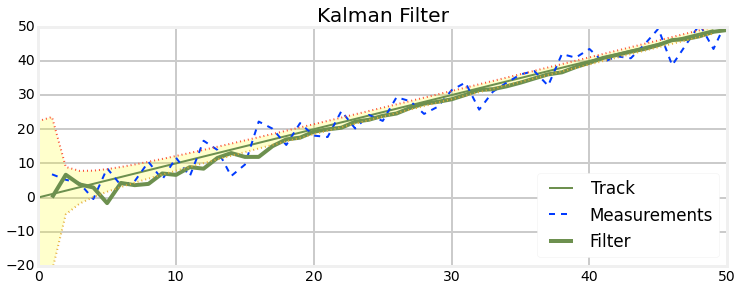

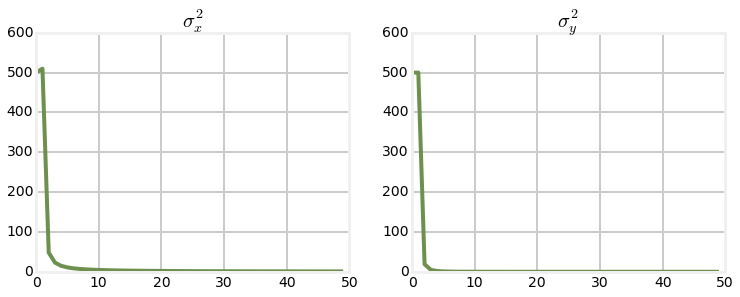

In [47]:
plot_track(noise_var=10, R_var=10., Q_var=0.01, count=50, y_lim=(-20, 50))

There is still a lot to learn, but we have implemented our first, full Kalman filter using the same theory and equations as published by Rudolf Kalman! Code very much like this runs inside of your GPS and phone, inside every airliner, inside of robots, and so on. 

The first plot plots the output of the Kalman filter against the measurements and the actual position of our dog (drawn in green). After the initial settling in period the filter should track the dog's position very closely. The yellow shaded portion between the black dotted lines shows 1 standard deviations of the filter's variance, which I explain in the next paragraph.

The next two plots show the variance of $x$ and of $\dot{x}$. If you look at the code, you will see that I have plotted the diagonals of $\mathbf{P}$ over time. Recall that the diagonal of a covariance matrix contains the variance of each state variable. So $\mathbf{P}[0,0]$ is the variance of $x$, and $\mathbf{P}[1,1]$ is the variance of $\dot{x}$. You can see that despite initializing $\mathbf{P}=(\begin{smallmatrix}500&0\\0&500\end{smallmatrix})$ we quickly converge to small variances for both the position and velocity. The covariance matrix $\mathbf{P}$ tells us the *theoretical* performance of the filter *assuming* everything we tell it is true. Recall from the Gaussian chapter that the standard deviation is the square root of the variance, and that approximately 68% of a Gaussian distribution occurs within one standard deviation. Therefore, if at least 68% of the filter output is within one standard deviation we can be sure that the filter is performing well. In the top chart I have displayed the one standard deviation as the yellow shaded area between the two dotted lines. To my eye it looks like perhaps the filter is slightly exceeding that bounds, so the filter probably needs some tuning. We will discuss this later in the chapter.

In the previous chapter we filtered very noisy signals with much simpler code than the code above. However, realize that right now we are working with a very simple example - an object moving through 1-D space and one sensor. That is about the limit of what we can compute with the code in the last chapter. In contrast, we can implement very complicated, multidimensional filter with this code merely by altering are assignments to the filter's variables. Perhaps we want to track 100 dimensions in financial models. Or we have an aircraft with a GPS, INS, TACAN, radar altimeter, baro altimeter, and airspeed indicator, and we want to integrate all those sensors into a model that predicts position, velocity, and accelerations in 3D (which requires 9 state variables). We can do that with the code in this chapter.

## Compare to Univariate Kalman Filter

The equations in this chapter look very different from the equations in the last chapter, yet I claimed the last chapter implemented a full 1-D (univariate) Kalman filter. 

Recall that the univariate equations for the update step are:
$$
\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}
\end{aligned}
$$

and that the 1-D equations for the predict step are:
$$
\begin{aligned}
\mu &= \mu_1+\mu_2, \\ \sigma^2 &= \sigma_1^2 + \sigma_2^2
\end{aligned}
$$

Let's implement a simple 1-D kalman filter using the Kalman filter from this chapter, and compare its output to the kalman filter from the previous chapter by plotting it. We will use a simple model of tracking an object that starts at x=0 and moves by 1 at each step. We will assume the arbitrary value 5 for the measurement noise and .02 for the process noise.

First, let's implement the filter from the last chapter:

In [48]:
from __future__ import division
import numpy as np
from numpy.random import randn
from filterpy.kalman import KalmanFilter

# 1-D Kalman filter equations
def predict(pos, variance, movement, movement_variance):
    return (pos + movement, variance + movement_variance)


def update (mu1, var1, mu2, var2):
    mean = (var1*mu2 + var2*mu1) / (var1+var2)
    variance = 1 / (1/var1 + 1/var2)
    return (mean, variance)

Now, let's implement the same thing using the kalman filter. I will implement it as a function that returns a KalmanFilter object so that you can run the analysis code several times with the KalmanFilter initialized to the same starting conditions each time.

In [49]:
from filterpy.kalman import KalmanFilter

def mkf_filter(R, Q):
    f = KalmanFilter(dim_x=1, dim_z=1, dim_u=1)
    f.P = 500.
    f.H = np.array([[1.]])
    f.F = np.array([[1.]])
    f.B = np.array([[1.]])
    f.Q = Q
    f.R = R
    
    return f

Finally, let's compare the two. I will plot the data from the 1-D Kalman filter as a blue line, and the output of the filter from this chapter as red dots. I wrote it as a function so you can easily modify the parameters and regenerate the plots.

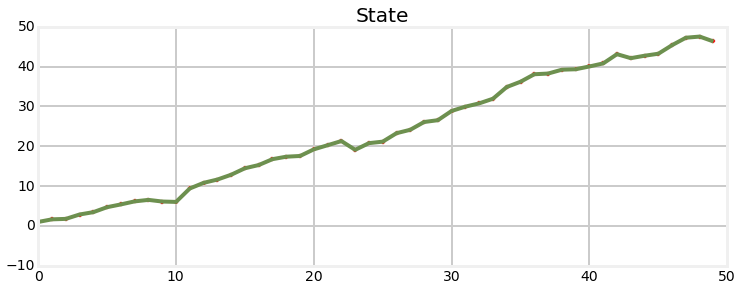

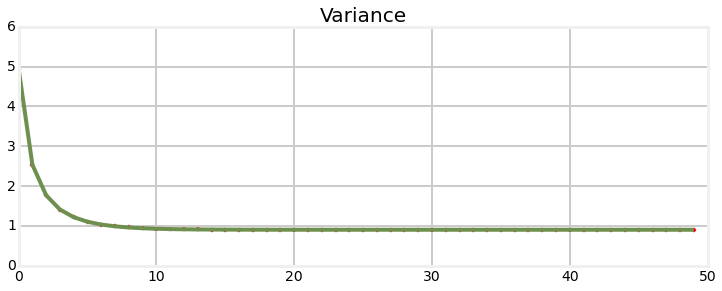

In [50]:
def plot_kf_compare(x0, p0, R, Q, move):
    # storage for filter output
    x1, x2 = [], []
    p1, p2 = [], []

    # initialize the filters
    f = mkf_filter(R, Q)
    f.x[0] = 0.
    f.P[0, 0] = p0
    pos = (x0, p0)
    for i in range(50):
        z = i*move + randn()
        pos = update(pos[0], pos[1], z, R)
        f.update(z)

        x1.append(pos[0])
        x2.append(f.x[0])

        p1.append(pos[1])
        p2.append(f.P[0, 0])

        u = move + randn()
        pos = predict(pos[0], pos[1], u, Q)
        f.predict(u=u)

    plt.scatter(range(len(x2)), x2, c='r')
    plt.title('State')
    plt.plot(x1)
    plt.xlim([0, 50])

    plt.figure()
    plt.plot(p1)
    plt.scatter(range(len(x2)), p2, c='r')
    plt.title('Variance')
    plt.xlim([0, 50])
    plt.show()
    
plot_kf_compare(x0=0., p0=500., R=5., Q=.2, move=1.)

### Discussion

As you can see, both filters produce the same results. Feel free to vary the initial guess, the measurement noise, and the process noise; so long as you make the same changes to both filters the output should be the same. This is a solid demonstration, albeit not a rigorous proof, that both filters in fact implement the same math for the 1-D case. 

## Converting the Multivariate Equations to the Univariate Case


As it turns out the Kalman filter equations are quite easy to deal with in one dimension, so let's do the mathematical proof. 

> **Note:** This section will provide you with a strong intuition into what the Kalman filter equations are actually doing. While this section is not strictly required, I recommend reading this section carefully as it should make the rest of the material easier to understand. It is not merely a proof of correctness that you would normally want to skip past! The equations look complicated, but they are actually doing something quite simple.

Let's start with the predict step, which is slightly easier. Here are the multivariate equations. 
$$
\begin{aligned}
\mathbf{x}^- &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{P^-} &= \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}
\end{aligned}
$$

The state $\mathbf{x}$ only has one variable, so it is a $1\times 1$ matrix. Our motion $\mathbf{u}$ is also be a $1\times 1$ matrix. Therefore, $\mathbf{F}$ and $\mathbf{B}$ must also be $1\times 1$ matrices. That means that they are all scalars, and we can write

$$x = Fx + Bu$$

Here the variables are not bold, denoting that they are not matrices or vectors. 

Our state transition is simple - the next state is the same as this state, so $F=1$. The same holds for the motion transition, so, $B=1$. Thus we have
$$x = x + u$$

which is equivalent to the Gaussian equation from the last chapter

$$ \mu = \mu_1+\mu_2$$

Hopefully the general process is clear, so now I will go a bit faster on the rest. Our other equation for the predict step is

$$\mathbf{P}^- = \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}$$

Again, since our state only has one variable $\mathbf{P}$ and $\mathbf{Q}$ must also be $1\times 1$ matrix, which we can treat as scalars, yielding  
$$P^- = FPF^\mathsf{T} + Q$$

We already know $F=1$. The transpose of a scalar is the scalar, so $F^\mathsf{T} = 1$. This yields

$$P^- = P + Q$$

which is equivalent to the Gaussian equation of 
$$\sigma^2 = \sigma_1^2 + \sigma_2^2$$

This proves that the multivariate equations are performing the same math as the univariate equations for the case of the dimension being 1.

Here our our multivariate Kalman filter equations for the update step.
$$
\begin{aligned}
\textbf{y} &= \mathbf{z} - \mathbf{H x^-}\\
\mathbf{K}&= \mathbf{P^-H}^\mathsf{T} (\mathbf{HP^-H}^\mathsf{T} + \mathbf{R})^{-1} \\
\mathbf{x}&=\mathbf{x}^- +\mathbf{K\textbf{y}} \\
\mathbf{P}&= (\mathbf{I}-\mathbf{KH})\mathbf{P^-}
\end{aligned}
$$

As above, all of the matrices become scalars. $H$ defines how we convert from a position to a measurement. Both are positions, so there is no conversion, and thus $H=1$. Let's substitute in our known values and convert to scalar in one step. One final thing you need to know - division is scalar's analogous operation for matrix inversion, so we will convert the matrix inversion to division.

$$
\begin{aligned}
y &= z - x^-\\
K &=P^- / (P^- + R) \\
x &=x +Ky \\
P &= (1-K)P^-
\end{aligned}
$$

Before we continue with the proof, I want you to look at those equations to recognize what a simple concept these equations implement. The residual $y$ is nothing more than the measurement minus the previous state. The gain $K$ is scaled based on how certain we are about the last prediction vs how certain we are about the measurement. We choose a new state $x$ based on the old value of $x$ plus the scaled value of the residual. Finally, we update the uncertainty based on how certain we are about the measurement. Algorithmically this should sound exactly like what we did in the last chapter.

So let's finish off the algebra to prove this. It's straightforward, and not at all  necessary for you to learn unless you are interested. Feel free to skim ahead to the last paragraph in this section if you prefer skipping the algebra.

Recall that the univariate equations for the update step are:
$$
\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}
\end{aligned}
$$

Here we will say that $\mu_1$ is the state $x$, and $\mu_2$ is the measurement $z$. That is entirely arbitrary, we could have chosen the opposite assignment. Thus it follows that that $\sigma_1^2$ is the state uncertainty $P$, and $\sigma_2^2$ is the measurement noise $R$. Let's substitute those in.

$$ \mu = \frac{Pz + Rx}{P+R} \\
\sigma^2 = \frac{1}{\frac{1}{P} + \frac{1}{R}}
$$

I will handle $\mu$ first. The corresponding equation in the multivariate case is

$$
\begin{aligned}
x &= x + Ky \\
 &= x + \frac{P}{P+R}(z-x) \\
 &= \frac{P+R}{P+R}x + \frac{Pz - Px}{P+R} \\
 &= \frac{Px + Rx + Pz - Px}{P+R} \\
 &= \frac{Pz + Rx}{P+R} \quad \blacksquare
\end{aligned}
$$

Now let's look at $\sigma^2$. The corresponding equation in the multivariate case is

$$ 
\begin{aligned}
P &= (1-K)P \\
 &= (1-\frac{P}{P+R})P \\
 &= (\frac{P+R}{P+R}-\frac{P}{P+R})P \\
  &= (\frac{P+R-P}{P+R})P \\
  &= \frac{RP}{P+R}\\
  &= \frac{1}{\frac{P+R}{RP}}\\
  &= \frac{1}{\frac{R}{RP} + \frac{P}{RP}} \\
  &= \frac{1}{\frac{1}{P} + \frac{1}{R}}
 \quad\blacksquare
\end{aligned}
$$

So we have proven that the multivariate equations are equivalent to the univariate equations when we only have one state variable. I'll close this section by recognizing one quibble - I hand waved my assertion that $H=1$ and $F=1$. In general we know this is not true. For example, a digital thermometer may provide measurement in volts, and we need to convert that to temperature, and we use $H$ to do that conversion. I left that issue out of the last chapter to keep the explanation as simple and streamlined as possible. It is very straightforward to add that generalization to the equations of the last chapter, redo the algebra above, and still have the same results. In practice we do not use the equations in the last chapter to perform Kalman filtering due to the material in the next section which demonstrates how much better the Kalman filter performs when we include unobserved variables. So I prefer to leave the equations from the last chapter in their simplest form so that they economically represent our central ideas without any extra complications.

## Exercise: Compare to a Filter That Incorporates Velocity

The last example did not use one of the fundamental insights of this chapter, unobserved variables. In this example velocity would the the unobserved variable. Write a Kalman filter that uses the state $\mathbf{x}=\begin{bmatrix}x & \dot{x}\end{bmatrix}^\mathsf{T}$ and compare it against the filter in the last exercise which used the state $\mathbf{x}=\begin{bmatrix}x\end{bmatrix}$.

In [51]:
# your code here

### Solution

We've already implemented a Kalman filter for position and velocity, so I will provide the code without much comment, and then plot the result.

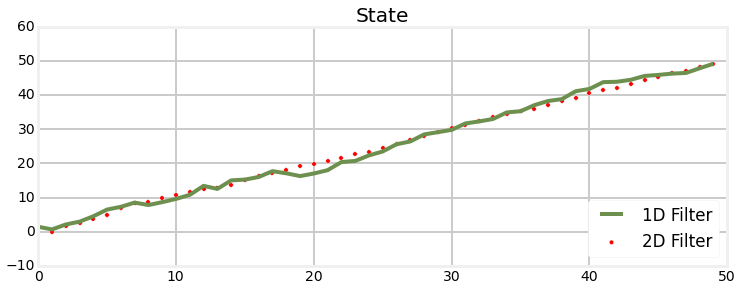

In [52]:
def pos_vel_filter(R, Q):
    f = KalmanFilter(dim_x=2, dim_z=1)
    f.R = R
    f.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=Q)
   
    f.F = np.array([[1, 1],
                    [0, 1]])  # state transition matrix
    f.H = np.array([[1, 0]])  # Measurement function
    return f

def plot_compare_pos_vel(x0, p0, R, Q, move):
    # storage for filter output
    x1, x2 = [], []

    # initialize the filters
    f1 = mkf_filter(R, Q)
    f1.x[0] = 0.
    f1.P[0, 0] = p0
    
    f2 = pos_vel_filter(R, Q)
    f2.x[0] = 0.
    f2.x[1] = 1.
    f2.P *= p0
    
    for i in range(50):
        u = move + randn()
        f1.predict(u=u)
        f2.predict(u=u)
        
        z = i*move + randn()
        f1.update(z)
        f2.update(z)
        
        x1.append(f1.x[0, 0])
        x2.append(f2.x[0, 0])

    plt.plot(x1, label='1D Filter')
    plt.scatter(range(len(x2)), x2, c='r', label='2D Filter')
    plt.title('State')
    plt.legend(loc=4)
    plt.xlim([0,50])
    plt.show()
    
plot_compare_pos_vel(x0=0., p0=500., R=5., Q=.2, move=1.)    

### Discussion

The output of the filter that incorporates velocity into the state produces much better output than the filter that only tracks position - the output is much closer to a straight line. We've already discussed why unobserved variables increase the precision of the filter, so I will not repeat that explanation here. But the last exercise and this one is intended to trigger a train of thought:

1. The equations in this chapter are mathematically equivalent to the equations in the last chapter when we are only tracking one state variable.
    
2. Therefore, the simple Bayesian reasoning we used in the last chapter applies to this chapter as well.

3. Therefore, the equations in this chapter might 'look ugly', but they really are just implementing multiplying and addition of Gaussians.

> The above might not seem worth emphasizing, but as we continue in the book the mathematical demands will increase significantly. It is easy to get lost in a thicket of linear algebra equations when you read a book or paper on optimal estimation. Any time you start getting lost, just go back to the basics of the predict/update cycle based on residuals between measurements and predictions and the meaning of the math will usually be much clearer. The math *looks* daunting, and can sometimes be very hard to solve analytically, but the concepts are quite simple.

## Adjusting the Filter

Your results will vary slightly depending on what numbers your random generator creates for the noise component of the noise, but the filter in the last section should track the actual position quite well. Typically as the filter starts up the first several predictions are quite bad, and varies a lot. But as the filter builds its state the estimates become much better. 

Let's start varying our parameters to see the effect of various changes. This is a *very normal* thing to be doing with Kalman filters. It is difficult, and often impossible to exactly model our sensors. An imperfect model means imperfect output from our filter. Engineers spend a lot of time tuning Kalman filters so that they perform well with real world sensors. We will spend time now to learn the effect of these changes. As you learn the effect of each change you will develop an intuition for how to design a Kalman filter. As I wrote earlier, designing a Kalman filter is as much art as science. The science is, roughly, designing the ${\mathbf{H}}$ and ${\mathbf{F}}$ matrices - they develop in an obvious manner based on the physics of the system we are modeling. The art comes in modeling the sensors and selecting appropriate values for the rest of our variables.

Let's look at the effects of the noise parameters ${\mathbf{R}}$ and ${\mathbf{Q}}$. We will want to see the effect of different settings for ${\mathbf{R}}$ and ${\mathbf{Q}}$, so I have hard coded our measurements in `zs` based on a variance of 50 meters. That is very large, but it magnifies the effects of various design choices on the graphs, making it easier to recognize what is happening. 

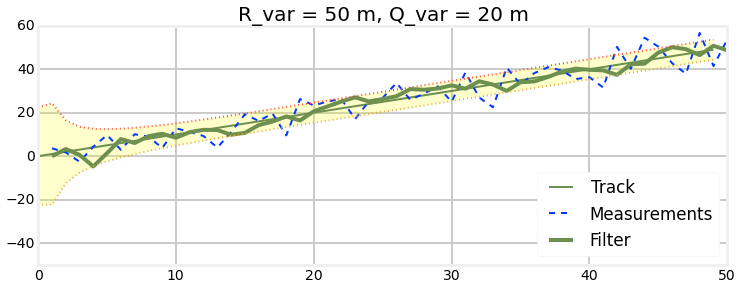

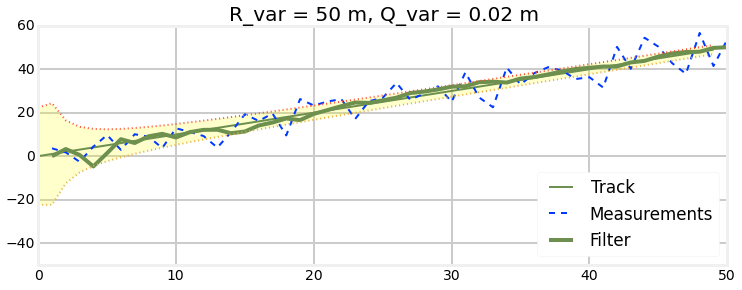

In [53]:
# dog = DogSensor(velocity=1, noise_var=50)
# zs = [dog.sense() for t in range(50)]
# I've hard coded zs to ensure we are all looking at the same data
zs = [3.59, 1.73, -2.575, 4.38, 9.71, 2.88, 10.08, 8.97, 3.74,
      12.81, 11.15, 9.25, 3.93, 11.11, 19.29, 16.20, 19.63,
      9.54, 26.27, 23.29, 25.18, 26.21, 17.1, 25.27, 26.86,
      33.70, 25.92, 28.82, 32.13, 25.0, 38.56, 26.97, 22.49,
      40.77, 32.95, 38.20, 40.93, 39.42, 35.49, 36.31, 31.56,
      50.29, 40.20, 54.49, 50.38, 42.79, 37.89, 56.69, 41.47, 53.66]
    
plot_track(data=zs, R_var=50, Q_var=20, count=50, plot_P=False, 
           title='R_var = 50 m, Q_var = 20 m')

plot_track(data=zs, R_var=50, Q_var=.02, count=50, plot_P=False, 
           title='R_var = 50 m, Q_var = 0.02 m')

The filter in the first plot should follow the noisy measurement almost exactly. In the second plot the filter should vary from the measurement quite a bit, and be much closer to a straight line than in the first graph. 

In the Kalman filter ${\mathbf{R}}$ is the *measurement noise* and ${\mathbf{Q}}$ is the *process uncertainty*. ${\mathbf{R}}$ is the same in both plots, so ignore it for the moment. Why does ${\mathbf{Q}}$ affect the plots this way?

Let's remind ourselves of what the term *process uncertainty* means. Consider the problem of tracking a ball. We can accurately model its behavior in static air with math, but if there is any wind our model will diverge from reality. 

In the first case we set `Q_var=20 m`, which is quite large. In physical terms this is telling the filter "I don't trust my motion prediction step" as we are saying that the variance in the velocity is 10. Strictly speaking, we are telling the filter there is a lot of external noise that we are not modeling with $\small{\mathbf{F}}$, but the upshot of that is to not trust the motion prediction step. So the filter will be computing velocity ($\dot{x}$), but then mostly ignoring it because we are telling the filter that the computation is extremely suspect. Therefore the filter has nothing to use but the measurements, and thus it follows the measurements closely. 

In the second case we set `Q_var=0.02 m`, which is quite small. In physical terms we are telling the filter "trust the motion computation, it is really good!". Again, more strictly this actually says there is very small amounts of process noise (variance 0.02 m), so the motion computation will be accurate. So the filter ends up ignoring some of the measurement as it jumps up and down, because the variation in the measurement does not match our trustworthy velocity prediction.

Now let's set `Q_var=0.2 m`, and bump `R_var` up to 10,000 m. This is telling the filter that the measurement noise is very large. 

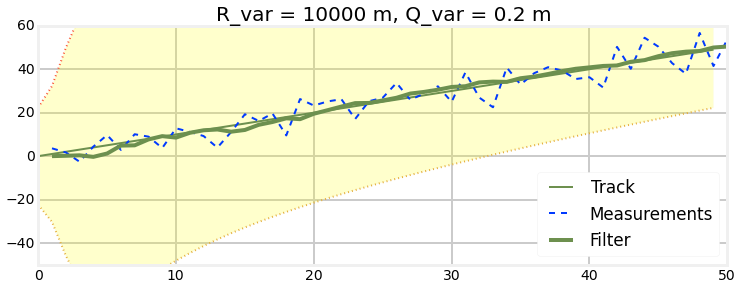

In [54]:
plot_track(data=zs, R_var=10000., Q_var=.2, count=50, plot_P=False, 
           title='R_var = 10000 m, Q_var = 0.2 m')

The effect of this can be subtle. We have created an suboptimal filter because the actual measurement noise variance is 30 m, not 10,000 m. By setting the filter's noise variance so high we force the filter to favor the prediction over the measurement. This can lead to apparently very smooth and good looking results. In the chart above the track may look extremely good to you since it follows the ideal path very closely. But, the 'great' behavior at the start should give you pause - the filter has not converged yet ($\mathbf{P}$ is still large) so it should not be able to be so close to the actual position. We can see that $\mathbf{P}$ has not converged because the entire chart is colored with the yellow background denoting the size of $\mathbf{P}$. Let's make $\mathbf{R}$ larger yet. Let's see the result of a bad initial guess for the position by guessing the initial position to be 20 m and the initial velocity to be 1 m/s.

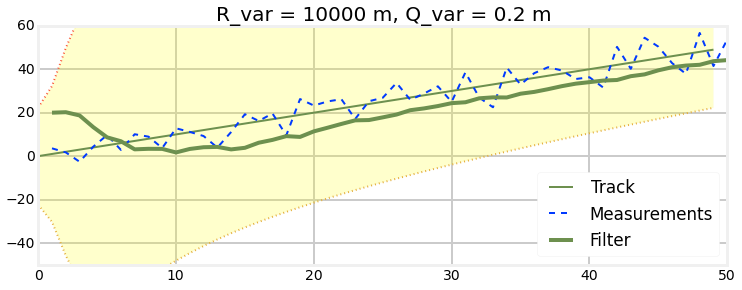

In [55]:
plot_track(data=zs, R_var=10000., Q_var=.2, count=50, 
           initial_x=np.array([20., 1.]), plot_P=False, 
           title='R_var = 10000 m, Q_var = 0.2 m')

Here we can see that the filter cannot acquire the actual track at all. This happens because even though the filter is getting reasonable good measurements it assumes that the measurements are bad, and eventually just predicts forward from a bad position at each step. If you think that perhaps that bad initial position would give similar results for a smaller measurement noise, let's set it back to the correct value of 50 m.

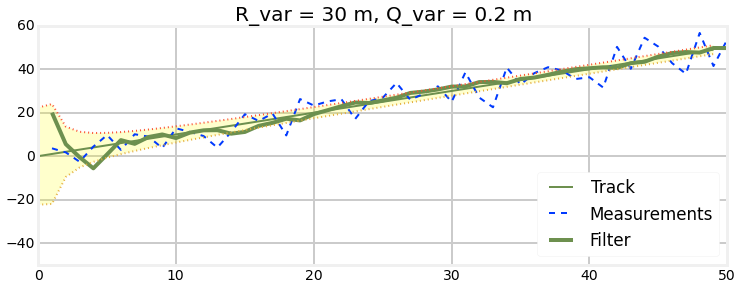

In [56]:
plot_track(data=zs, R_var=30, Q_var=.2, count=50, 
           initial_x=np.array([20., 1.]), plot_P=False, 
           title='R_var = 30 m, Q_var = 0.2 m')

Here we see that the filter initially struggles for several iterations to acquire the track, but then it accurately tracks our dog. In fact, this is nearly optimum - we have not designed $\mathbf{Q}$ optimally, but $\mathbf{R}$ is optimal, and thus will yield optimal results. Recall that our rule of thumb for the variance of $\mathbf{Q}$ was to set it between $\frac{1}{2}\Delta a$ to $\Delta a$, where $\Delta a$ is the maximum amount that the acceleration will change between sample period. This only applies for the assumption we are making in this chapter - that acceleration is constant and uncorrelated between each time period. In the Kalman Math chapter we will discuss several different ways of designing $\mathbf{Q}$.

To some extent you can get similar looking output by varying either ${\mathbf{R}}$ or ${\mathbf{Q}}$, but I urge you to not 'magically' alter these until you get output that you like. Always think about the physical implications of these assignments, and vary ${\mathbf{R}}$ and/or ${\mathbf{Q}}$ based on your knowledge of the system you are filtering.

## A Detailed Examination of the Covariance Matrix

So far I have not given a lot of coverage of the covariance matrix $\mathbf{P}$. It is nothing more than the variance of our state - such as the position and velocity of our dog. It has many elements in it, but don't be daunted; we will learn how to interpret a very large $9{\times}9$ covariance matrix, or even larger.

Recall the beginning of the chapter, where we provided the equation for the covariance matrix. It read:

$$
\Sigma = \begin{pmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{pmatrix}
$$

(The Kalman filter literature uses $\mathbf{P}$ for $\Sigma$; they both denote the same thing.)

The diagonal contains the variance of each of our state variables. So, if our state variables are

$$\textbf{x}=\begin{bmatrix}x\\\dot{x}\end{bmatrix}$$

and the covariance matrix happens to be
$$\textbf{P}=\begin{bmatrix}2&0\\0&6\end{bmatrix}$$

we know that the variance of $x$ is 2 m, and the variance of $\dot{x}$ is 6 m/s. The off diagonal elements are all 0, so we also know that $x$ and $\dot{x}$ are not correlated. Recall the ellipses that we drew of the covariance matrices. Let's look at the ellipse for the matrix.

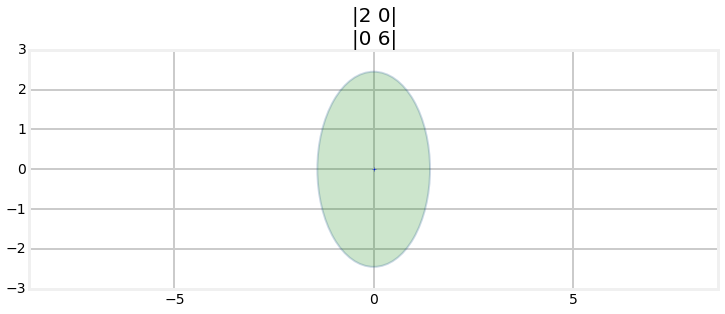

In [57]:
P = np.array([[2., 0.], 
              [0., 6.]])
stats.plot_covariance_ellipse((0, 0), P, facecolor='g', alpha=0.2,
                              title='|2 0|\n|0 6|')

Of course it is unlikely that the position and velocity of an object remain uncorrelated for long. Let's look at a more typical covariance matrix

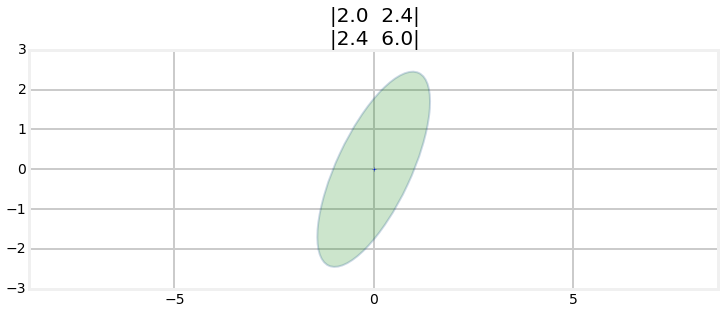

In [58]:
P = np.array([[2.0, 2.4],
              [2.4, 6.0]])
stats.plot_covariance_ellipse((0, 0), P, facecolor='g', alpha=0.2, 
                              title='|2.0  2.4|\n|2.4  6.0|')

Here the ellipse is slanted, signifying that $x$ and $\dot{x}$ are correlated (and, of course, dependent - all correlated variables are dependent). You may or may not have noticed that the off diagonal elements were set to the same value, 2.4. This was not an accident. Let's look at the equation for the covariance for the case where the number of dimensions is two.

$$
\mathbf{P} = \begin{pmatrix}
  \sigma_1^2 & \sigma_{1,2} \\
  \sigma_{2,1} &\sigma_2^2 
 \end{pmatrix}
$$

Here the notation $\sigma_{1,2}$ means the covariance of variables 1 and 2 where that is defined as

$$\sigma_{i,j}
= \mathrm{cov}(X_i, X_j) = \mathrm{E}\begin{bmatrix}
(X_i - \mu_i)(X_j - \mu_j)
\end{bmatrix}$$


We can rearrange the terms to get

$$\begin{aligned}
\sigma_{i,j} &= \mathrm{E}\begin{bmatrix}(X_i - \mu_i)(X_j - \mu_j)\end{bmatrix} \\ 
&= \mathrm{E}\begin{bmatrix} (X_j - \mu_j)(X_i - \mu_i)\end{bmatrix} \\ 
&= \sigma_{j,i}
\end{aligned}$$


In general, we can state that $\sigma_{i,j}=\sigma_{j,i}$.

Let's get back to concrete terms. Let's start by revisiting plotting a track. I will hard code the data and noise to avoid being at the mercy of the random number generator, which might generate data that does not illustrate what I want to talk about. I will start with `P=500`.

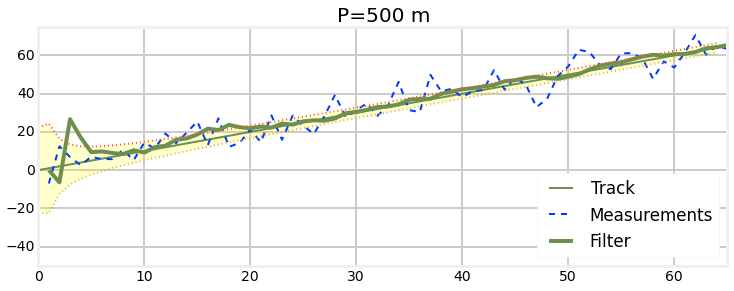

In [59]:
# guarantee the noise is the same each time so I can be sure of
# what the graphs look like.
zs = [-6.947, 12.467, 6.899, 2.643, 6.980, 5.820, 5.788, 10.614, 5.210, 
      14.338, 11.401, 19.138, 14.169, 19.572, 25.471, 13.099, 27.090,
      12.209, 14.274, 21.302, 14.678, 28.655, 15.914, 28.506, 23.181, 
      18.981, 28.197, 39.412, 27.640, 31.465, 34.903, 28.420, 33.889, 
      46.123, 31.355, 30.473, 49.861, 41.310, 42.526, 38.183, 41.383, 
      41.919, 52.372, 42.048, 48.522, 44.681, 32.989, 37.288, 49.141, 
      54.235, 62.974, 61.742, 54.863, 52.831, 61.122, 61.187, 58.441, 
      47.769, 56.855, 53.693, 61.534, 70.665, 60.355, 65.095, 63.386]

plot_track(data=zs, R_var=50., Q_var=.2, P=500., count=len(zs), 
           plot_P=False, title='P=500 m')

Looking at the output we see a very large spike in the filter output at the beginning. If you look at the data (dotted red line) you will see a corresponding, smaller spike in the beginning of the data. We set `P=500 m`, which corresponds to $\text{P}=[\begin{smallmatrix}500&0\\0&500\end{smallmatrix}]$. We now have enough information to understand what this means, and how the Kalman filter treats it. The 500 in the upper left hand corner corresponds to $\sigma^2_x$; therefore we are saying the standard deviation of `x` is $\sqrt{500}$, or roughly 22.36 m. If we recall how standard deviations work, roughly 99% of the samples occur withing $3\sigma$, therefore `P=500` is telling the Kalman filter that the initial estimate could be up to 67 meters off. That is a pretty large error, so when the measurement spikes the Kalman filter distrusts its own estimate and jumps wildly to try to incorporate the measurement. Then, as the filter evolves $\mathbf{P}$ quickly converges to a more realistic value.

Now let us see the effect of a smaller initial value for `P`.

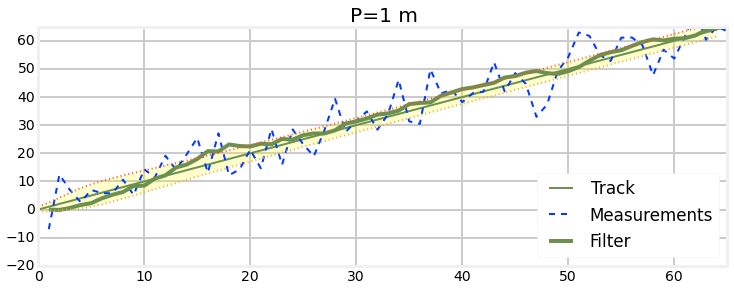

In [60]:
plot_track(data=zs, R_var=50., Q_var=.2, P=1., count=len(zs), 
           y_lim=(-20,65), plot_P=False, title='P=1 m')

This *looks* fantastic at first blush. The plot does not have the spike that the former plot did; the filter starts tracking the measurements and doesn't take any time to settle to the signal. However, if we look at the plots for P you can see that there is an initial spike for the variance in position, and that it never really converges. Poor design leads to a long convergence time, and suboptimal results. 

So despite the filter tracking very close to the actual signal we cannot conclude that the 'magic' is to just use a small $\text{P}$. Yes, this will avoid having the Kalman filter take time to accurately track the signal, but if we are truly uncertain about the initial measurements this can cause the filter to generate very bad results. If we are tracking a living object we are probably very uncertain about where it is before we start tracking it. On the other hand, if we are filtering the output of a thermometer, we are just as certain about the first measurement as the 1000th. For your Kalman filter to perform well you must set $\text{P}$ to a value that truly reflects your knowledge about the data. 

Let's see the result of a bad initial estimate coupled with a very small $\text{P}$ We will set our initial estimate at 100m (whereas the dog starts at 0m), but set `P=1 m`.

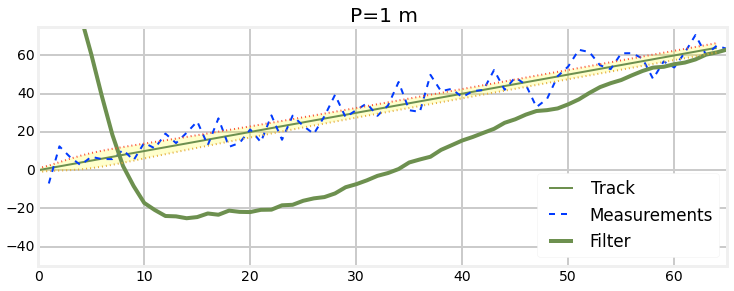

In [61]:
x = np.array([100., 0.]).T
plot_track(data=zs, R_var=50., Q_var=.2, P=1., initial_x=x,
           count=len(zs), plot_P=False, title='P=1 m')

We can see that the initial estimates are terrible and that it takes the filter a long time to start converging onto the signal . This is because we told the Kalman filter that we strongly believe in our initial estimate of 100m and were incorrect in that belief.

Now, let's provide a more reasonable value for P and see the difference.

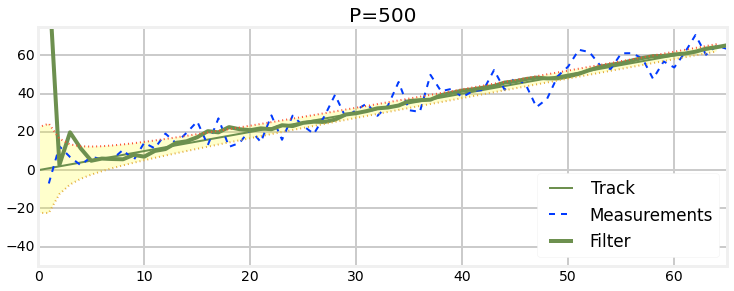

In [62]:
x = np.array([100, 0]).T
plot_track(data=zs, R_var=50, Q_var=.02, P=500., initial_x=x,
           count=len(zs), plot_P=False, title='P=500')

In this case the Kalman filter is very uncertain about the initial state, so it converges onto the signal much faster. It is producing good output after only 5 to 6 evolutions. With the theory we have developed so far this is about as good as we can do. However, this scenario is a bit artificial; if we do not know where the object is when we start tracking we do not initialize the filter to some arbitrary value, such as 0 m or 100 m. Instead, we would normally take the first measurement, use that to initialize the Kalman filter, and proceed from there. But this is an engineering decision. You really need to understand the domain in which you are working and initialize your filter on the best available information. For example, suppose we were trying to track horses in a horse race. The initial measurements might be very bad, and provide you with a position far from the starting gate. We know that the horse must start at the starting gate; initializing the filter to the initial measurement would lead to suboptimal results. In this scenario we would want to always initialize the Kalman filter with the starting gate position. 

If we have the luxury of not needing to perform the filtering in real time, as the data comes in, we can take advantage of other techniques. We can 'eyeball' the data and see that  the initial measurements are giving us reasonable values for the dog's position because we can see all of the data at once. A *fixed lag smoother* will look N steps ahead before computing the state, and other filters will do things like first run forwards, than backwards over the data. This will be the subject of the Smoothing chapter. It is worthwhile to keep in mind that whenever possible we should prefer this sort of batch processing because it takes advantage of all available information. It does incur cost of additional processing time and increased storage due to the requirement to store some or all of the measurements. And, of course, batch processing does not work if we need real time results, such as when using GPS in our car.

Lets do another Kalman filter for our dog, and this time plot the covariance ellipses on the same plot as the position.

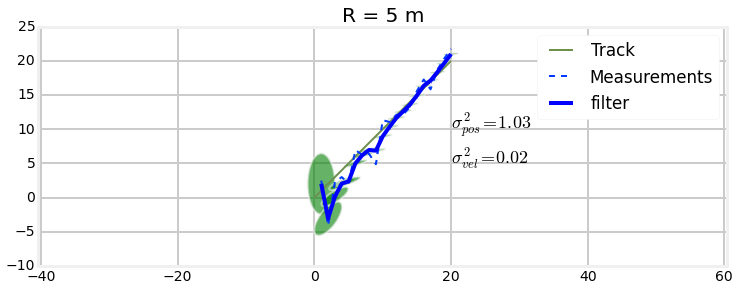

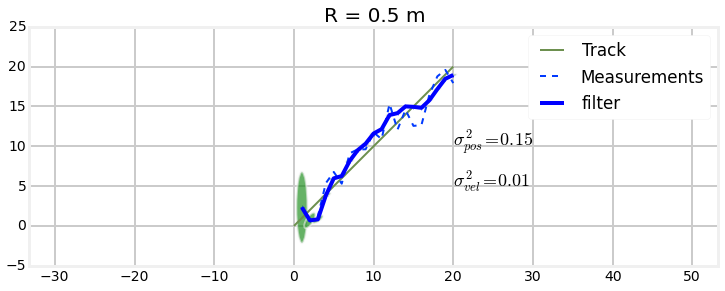

In [63]:
def plot_track_ellipses(noise, count, R, Q=0, P=20., plot_P=True, 
                        title='Kalman Filter'):
    dog = DogSensor(velocity=1, noise_var=noise)
    f = dog_tracking_filter(R=R, Q=Q, cov=P)

    ps = []
    zs = []
    cov = []
    for t in range(count):
        z = dog.sense()
        f.update(z)
        ps.append(f.x[0])
        cov.append(f.P)
        zs.append(z)
        f.predict()

    bp.plot_track([0, count], [0, count])
    bp.plot_measurements(range(1,count + 1), zs)
    plt.plot(range(1,count + 1), ps, c='b', label='filter')
    plt.legend(loc='best')
    plt.title(title)

    for i,p in enumerate(cov):
        stats.plot_covariance_ellipse(
              (i+1, ps[i]), cov=p, axis_equal=False, 
               facecolor='g', edgecolor=None, alpha=0.6)

        if i == len(cov)-1:
            s = ('$\sigma^2_{pos} = %.2f$' % p[0,0])
            plt.text (20, 10, s, fontsize=18)
            s = ('$\sigma^2_{vel} = %.2f$' % p[1, 1])
            plt.text (20, 5, s, fontsize=18)
    plt.axis('equal')
    plt.show()

plot_track_ellipses(noise=5, R=5, Q=.2, count=20, title='R = 5 m')
plot_track_ellipses(noise=5, R=.5, Q=.2, count=20, title='R = 0.5 m')

If you are viewing this in IPython Notebook or on the web, here is an animation of the filter filtering the data. I've tuned the filter parameters such that it is easy to see a change in $\mathbf{P}$ as the filter progresses.
<img src='animations/multivariate_track1.gif'>

The output on these is a bit messy, but you should be able to see what is happening. In both plots we are drawing the covariance matrix for each point. We start with the covariance $\mathbf{P}=(\begin{smallmatrix}50&0\\0&50\end{smallmatrix})$, which signifies a lot of uncertainty about our initial belief. After we receive the first measurement the Kalman filter updates this belief, and so the variance is no longer as large. In the top plot the first ellipse (the one on the far left) should be a slightly squashed ellipse. As the filter continues processing the measurements the covariance ellipse quickly shifts shape until it settles down to being a long, narrow ellipse tilted in the direction of movement.

Think about what this means physically. The x-axis of the ellipse denotes our uncertainty in position, and the y-axis our uncertainty in velocity. So, an ellipse that is taller than it is wide signifies that we are more uncertain about the velocity than the position. Conversely, a wide, narrow ellipse shows high uncertainty in position and low uncertainty in velocity. Finally, the amount of tilt shows the amount of correlation between the two variables. 

The first plot, with `R=5 m`, finishes up with an ellipse that is wider than it is tall. If that is not clear I have printed out the variances for the last ellipse in the lower right hand corner. The variance for position is 3.85 m, and the variance for velocity is 3.0 m. 

In contrast, the second plot, with `R=0.5 m`, has a final ellipse that is taller than wide. The ellipses in the second plot are all much smaller than the ellipses in the first plot. This stands to reason because a small $\small\mathbf{R}$ implies a small amount of noise in our measurements. Small noise means accurate predictions, and thus a strong belief in our position. 

## Question: Explain Ellipse Differences

Why are the ellipses for $\mathbf{R}=5 m$ shorter, and more tilted than the ellipses for $\mathbf{R}=0.5 m$. Hint: think about this in the context of what these ellipses mean physically, not in terms of the math. If you aren't sure about the answer,change $\mathbf{R}$ to truly large and small numbers such as 100 m and 0.1 m, observe the changes, and think about what this means. 

### Solution

The $x$ axis is for position, and $y$ is velocity. An ellipse that is vertical, or nearly so, says there is no correlation between position and velocity, and an ellipse that is diagonal says that there is a lot of correlation. Phrased that way, it sounds unlikely - either they are correlated or not. But this is a measure of the *output of the filter*, not a description of the actual, physical world. When $\mathbf{R}$ is very large we are telling the filter that there is a lot of noise in the measurements. In that case the Kalman gain $\mathbf{K}$ is set to favor the prediction over the measurement, and the prediction comes from the velocity state variable. So, there is a large correlation between $x$ and $\dot{x}$. Conversely, if $\mathbf{R}$ is small, we are telling the filter that the measurement is very trustworthy, and $\mathbf{K}$ is set to favor the measurement over the prediction. Why would the filter want to use the prediction if the measurement is nearly perfect? If the filter is not using much from the prediction there will be very little correlation reported. 

**This is a critical point to understand!**. The Kalman filter is just a mathematical model for a real world system. A report of little correlation *does not mean* there is no correlation in the physical system, just that there was no *linear* correlation in the mathematical model. It's just a report of how much measurement vs prediction was incorporated into the model.  

Let's bring that point home with a truly large measurement error. We will set $\mathbf{R}=500 m$. Think about what the plot will look like before scrolling down. To emphasize the issue, I will set the amount of noise injected into the measurements to 0, so the measurement will exactly equal the actual position. 

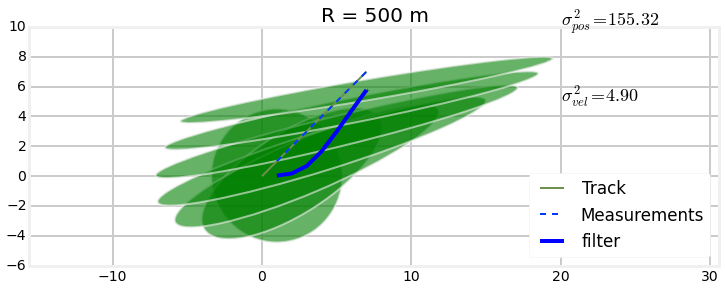

In [64]:
plot_track_ellipses(noise=0., R=500., Q=.2, count=7, title='R = 500 m')

I hope the result was what you were expecting. The ellipse quickly became very wide and not very tall. It did this because the Kalman filter mostly used the prediction vs the measurement to produce the filtered result. We can also see how the filter output is slow to acquire the track. The Kalman filter assumes that the measurements are extremely noisy, and so it is very slow to update its estimate for $\dot{x}$. 

Keep looking at these plots until you grasp how to interpret the covariance matrix $\mathbf{P}$. When you start dealing with a, say, $9{\times}9$ matrix it may seem overwhelming - there are 81 numbers to interpret. Just break it down - the diagonal contains the variance for each state variable, and all off diagonal elements are the product of two variances and a scaling factor $p$. You will not be able to plot a $9{\times}9$ matrix on the screen because it would require living in 10-D space, so you have to develop your intuition and understanding in this simple, 2-D case. 

> **sidebar**: when plotting covariance ellipses, make sure to always use *plt.axis('equal')* in your code. If the axis use different scales the ellipses will be drawn distorted. For example, the ellipse may be drawn as being taller than it is wide, but it may actually be wider than tall.

## Batch Processing

The Kalman filter is designed as a recursive algorithm - as new measurements come in we immediately create a new estimate. But it is very common to have a set of data that have been already collected which we want to filter. Kalman filters can always be run in a *batch* mode, where all of the measurements are filtered at once. We have implemented this in `KalmanFilter.batch_filter()`. Internally, all the function does is loop over the measurements and collect the resulting state and covariance estimates in arrays. It may seem a bit trivial, but you will almost always want to do this if you can for several reasons. First, it will execute a bit quicker than if you implement the loop yourself. Second, the logic in your code will be a bit cleaner, and you will have a reduced chance of bugs. Third, and most importantly, it you batch process your data you can then use an extremely powerful technique to generate far smoother results than you have seen so far. We will present that technique in the next section; here I will show you how to use `KalmanFilter.batch_filter()`.

All you have to do is collect your measurements into an array or list. Maybe it is in a CSV file, for example.

    zs = read_altitude_from_csv()

Or maybe you will generate it using a generator:

    zs = [some_func(i) for i in range(1000)]
    
Just do whatever it takes to get your measurements in an array.

Now we will just call the `batch_filter()` method.

    Xs, Ps, Xs_pred, Ps_pred = kfilter.batch_filter(zs)
    
The function takes the list/array of measurements, filters it, and returns a list of state estimates (Xs), covariance matrices (Ps), and the predictions for the same (Xs_pred, Ps_pred).

Here is a complete example drawing from the code above

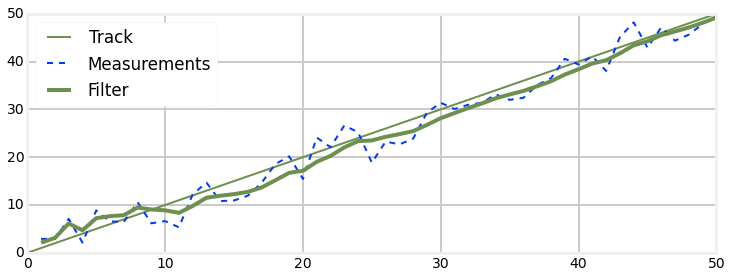

In [65]:
dog = DogSensor(velocity=1, noise_var=10.)
f = dog_tracking_filter(R=3., Q=.02, cov=P)
count = 50
zs = [dog.sense() for t in range(count)]
Xs, _, _, _ = f.batch_filter(zs)

bp.plot_track([0, count], [0, count])
bp.plot_measurements(range(1, count + 1), zs)
bp.plot_filter(range(1, count + 1), Xs[:,0])
plt.legend(loc='best')
plt.show()

## Smoothing the Results

I have an entire chapter on using the Kalman filter to smooth data; I will not repeat the chapter's information here. However, it is so easy to use, and offers such a profoundly improved output that I will tease you will a few examples. The smoothing chapter is not especially difficult; you are sufficiently prepared to read it now.

Briefly, the recursive form of Kalman filtering that we have been using up to now use information from the past to generate the current estimate. Recall the last section, where we used batch processing to filter a collection of measurements. This implies that we know now only the past, but the future! This is a key insight.

Let's assume that  we are tracking a car. Suppose we get a noisy measurement that implies that the car is starting to turn to the left, but the state function has predicted that the car is moving straight. The Kalman filter has no choice but to move the state estimate somewhat towards the noisy measurement, as it cannot judge whether this is just a particularly noisy measurement or the true start of a turn. 

However, if we have measurements from the future we can often figure out if a turn was made or not. Suppose the subsequent measurements all continue turning left. We can then be sure that the measurement was not very noisy, but instead a true indication that a turn was initiated. On the other hand, if the subsequent measurements continued on in a straight line we would know that the measurement was noisy and should be mostly ignored.

We will not develop the math or algorithm here, I will just show you how to call the algorithm in `filterpy`. The algorithm that we have implemented is called an *RTS smoother*, after the three inventors of the algorithm: Rauch, Tung, and Striebel. The routine is `KalmanFilter.rts_smoother()`. Using it is trivial; we pass in the means and covariances computed from the `batch_filter` step, and receive back the smoothed means, covariances, and Kalman gain.

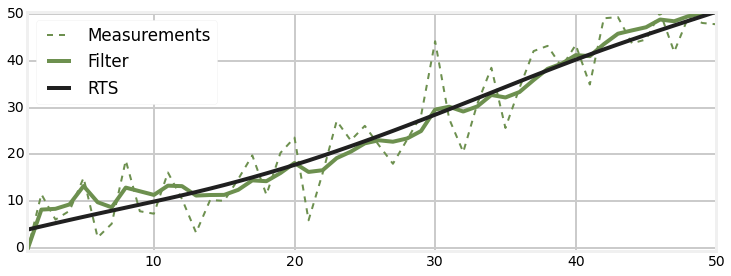

In [66]:
from numpy.random import seed
dog = DogSensor(velocity=1, noise_var=40.)
f = dog_tracking_filter(R=3., Q=.2, cov=P)
count = 50
seed(8923)
zs = [dog.sense() for t in range(count)]
Xs, Covs, _, _ = f.batch_filter(zs)
Ms, Ps, _ = f.rts_smoother(Xs, Covs)

bp.plot_measurements(range(1, count + 1), zs)
bp.plot_filter(range(1, count + 1), Xs[:, 0])
plt.plot(range(1,  count + 1), Ms[:, 0], label='RTS')
plt.legend(loc='best')
plt.show()

This output is fantastic!. Two things are very apparent to me in this chart. First, the RTS output is much, much smoother than the KF output. Second, it is almost always more accurate than the KF output (we will examine this claim in detail in the **Smoothing** chapter).

While you can usually find isolated sections where the KF produces a more accurate estimate than the RTS smoother, the RTS almost always significantly outperforms the KF. If you are able to batch process your data, there is no reason to not use the RTS algorithm.

We cannot always wait to collect all of our data before we filter it. If so, that means that we cannot use the RTS filter, but we may still have options. The **Smoothing** chapter discusses various strategies that you can use, and it is a mandatory (and easy) chapter if you want to achieve the best possible results from your filtering.

Let's wrap this up by looking at the velocity estimates of the two filters.

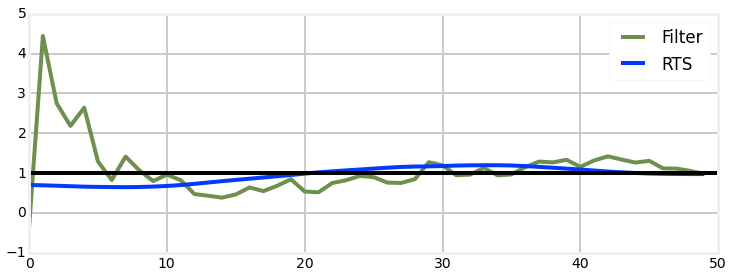

In [67]:
dog = DogSensor(velocity=1, noise_var=40.)
f = dog_tracking_filter(R=3., Q=.2, cov=P)
count = 50
seed(8923)
zs = [dog.sense() for t in range(count)]
Xs, Covs, _, _ = f.batch_filter(zs)
Ms, Ps, _ = f.rts_smoother(Xs, Covs)
bp.plot_filter(Xs[:, 1])
plt.plot(Ms[:, 1], label='RTS')
plt.legend(loc='best')
plt.gca().axhline(1, c='k')
plt.show()

The improvement in the velocity, which is an unobserved variable, is even more dramatic. 

Since we are plotting velocities let's look at what the the 'raw' velocity is, which we can compute by subtracting subsequent measurements. We see below that the noise swamps the signal, causing the computed values to be essentially worthless. I show this to reiterate the importance of using Kalman filters to compute velocities, accelerations, and even higher order values. I use a Kalman filter even when my measurements are so accurate that I am willing to use them unfiltered if I am also interested in the velocities and/or accelerations. Even a very small error in a measurement gets magnified when computing velocities. 

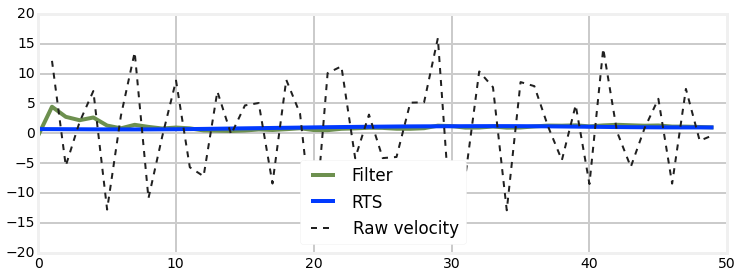

In [68]:
dx = np.diff(zs, axis=0)
plt.plot(Xs[:, 1], label='Filter')
plt.plot(Ms[:, 1], label='RTS')
plt.plot(range(1,count), dx, c='r',ls='--', lw=2, label='Raw velocity')
plt.legend(loc='best')
plt.show()

## Walking Through the KalmanFilter Code (Optional)

** author's note: this code is somewhat old. This section needs to be edited; I would not pay a lot of attention to it right now. **

The kalman filter code that we are using is implemented in my Python library `FilterPy`. If you are interested in the full implementation of the filter you should look in `filterpy\kalman\kalman_filter.py`. In the following I will present a simplified implementation of the same code. The code in the library handles issues that are beyond the scope of this chapter, such as numerical stability and support for the extended Kalman filter, subject of a later chapter. 

The code is implemented as the class `KalmanFilter`. Some Python programmers are not a fan of object oriented (OO) Python, and eschew classes. I do not intend to enter into that battle other than to say that I have often seen OO abused. Here I use the class to encapsulate the data that is pertinent to the filter so that you do not have to store and pass around a half dozen variables everywhere.

The method `__init__()` is used by Python to create the object. Here is the method 

    def __init__(self, dim_x, dim_z):
        """ Create a Kalman filter. You are responsible for setting the 
        various state variables to reasonable values; the defaults below will
        not give you a functional filter.
        
        Parameters
        ----------
        dim_x : int
            Number of state variables for the Kalman filter. For example, if
            you are tracking the position and velocity of an object in two
            dimensions, dim_x would be 4.
            
            This is used to set the default size of P, Q, and u
           
        dim_z : int
            Number of of measurement inputs. For example, if the sensor
            provides you with position in (x,y), dim_z would be 2.            
        """
        
        self.dim_x = dim_x
        self.dim_z = dim_z

        self.x = np.zeros((dim_x, 1)) # state
        self.P = np.eye(dim_x)        # uncertainty covariance
        self.Q = np.eye(dim_x)        # process uncertainty
        self.u = 0                    # control input vector
        self.B = np.zeros((dim_x, 1))
        self.F = 0                    # state transition matrix
        self.H = 0                    # Measurement function
        self.R = np.eye(dim_z)        # state uncertainty

        # identity matrix. Do not alter this.
        self._I = np.eye(dim_x)

More than anything this method exists to document for you what the variable names are in the filter. To do anything useful with this filter you will have to modify most of these values. Some are set to useful values. For example, `R` is set to an identity matrix; if you want the diagonals of `R` to be 10. you may write (as we did earlier in this chapter) `my_filter.R += 10.`.

The names used for each variable matches the math symbology used in this chapter. Thus, `self.P` is the covariance matrix, `self.x` is the state, and so on.

The predict function implements the predict step of the Kalman equations, which are 

$$
\begin{aligned}
\mathbf{x}^- &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{P}^- &= \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q} 
\end{aligned}
$$

The corresponding code is

    def predict(self):        
        self.x = self.F.dot(self.x) + self.B.dot(self.u)
        self.P = self.F.dot(self.P).dot(self.F.T) + self.Q

I haven't discussed the use of NumPy much until now, but this method illustrates the power of that package. We use NumPy's `array` class to store our data and perform the linear algebra for our filters. `array` implements matrix multiplication using the `.dot()` method; if you use `*` you will get element-wise multiplication. As a heavy user of linear algebra this design is somewhat distressing as I use matrix multiplication far more often than element-wise multiplication. However, this design is due to historical developments in the library and we must live with it. The Python community has recognized this problem, and in Python 3.5 we will have the `@` operator to implement matrix multiplication. 

With that in mind, the Python code `self.F.dot(self.x)` implements the math expression $\mathbf{F x}$.

NumPy's `array` implements matrix transposition by using the `.T` property. Therefore, `F.T` is the python implementation of $\mathbf{F}^\mathsf{T}$.

The `update()` method implements the update equations of the Kalman filter, which are

$$
\begin{aligned}
\mathbf{y} &= \mathbf{z} - \mathbf{H}\mathbf{x^-} \\
\mathbf{K} &= \mathbf{P} \mathbf{H}^\mathsf{T} (\mathbf{H} \mathbf{P^-} \mathbf{H}^\mathsf{T} +\mathbf{R})^{-1} \\
\mathbf{x} &= \mathbf{x}^- + \mathbf{K} \mathbf{y} \\
\mathbf{P} &= (\mathbf{I} - \mathbf{K} \mathbf{H})\mathbf{P^-}
\end{aligned}
$$

The corresponding code is:

    def update(self, Z, R=None):
        """
        Add a new measurement (Z) to the kalman filter. If Z is None, nothing
        is changed.

        Optionally provide R to override the measurement noise for this
        one call, otherwise  self.R will be used.

        self.residual, self.S, and self.K are stored in case you want to
        inspect these variables. Strictly speaking they are not part of the
        output of the Kalman filter, however, it is often useful to know
        what these values are in various scenarios.
        """

        if Z is None:
            return

        if R is None:
            R = self.R
        elif np.isscalar(R):
            R = np.eye(self.dim_z) * R

        # error (residual) between measurement and prediction
        self.residual = Z - self.H.dot(self.x)

        # project system uncertainty into measurement space
        self.S = self.H.dot(self.P).dot(self.H.T) + R

        # map system uncertainty into kalman gain
        self.K = self.P.dot(self.H.T).dot(linalg.inv(self.S))

        # predict new x with residual scaled by the kalman gain
        self.x += self.K.dot(self.residual)

        KH = self.K.dot(self.H)
        I_KH = self._I - KH
        self.P = (I_KH.dot(self.P.dot(I_KH.T)) +
                 self.K.dot(self.R.dot(self.K.T)))

There are a few more complications in this piece of code compared to `predict()` but it should still be quite clear. 

The first complication are the lines:

        if Z is None:
            return
            
This just lets you deal with missing data in a natural way. It is typical to use `None` to indicate the absence of data. If there is no data for an update we skip the update equations. This bit of code means you can write something like:

    z = read_sensor()    # may return None if no data
    my_kf.update(z)
    
instead of:
    z = read_sensor()
    if z is not None:
        my_kf.update(z)
        
Reasonable people will argue whether my choice is cleaner, or obscures the fact that we do not update if the measurement is `None`. Having written a lot of avionics code my proclivity is always to do the safe thing. If we pass 'None' into the function I do not want an exception to occur; instead, I want the reasonable thing to happen, which is to just return without doing anything. If you feel that my choice obscures that fact, go ahead and write the explicit `if` statement prior to calling `update()` and get the best of both worlds.

The next bit of code lets you optionally pass in a value to override `R`. It is common for the sensor noise to vary over time; if it does you can pass in the value as the optional parameter `R`.

        if R is None:
            R = self.R
        elif np.isscalar(R):
            R = np.eye(self.dim_z) * R
            
This code will use self.R if you do not provide a value for `R`. If you did provide a value, it will check if you provided a scalar (number); if so it constructs a matrix of the correct dimension for you. Otherwise it assumes that you passed in a matrix of the correct dimension.

The rest of the code implements the Kalman filter equations, with one exception. Instead of implementing 

$$\mathbf{P} = (\mathbf{I} - \mathbf{KH})\mathbf{P}^-$$

it implements the somewhat more complicated form 

$$\mathbf{P} = (\mathbf{I} - \mathbf{KH})\mathbf{P}^-(\mathbf{I} - \mathbf{KH})^\mathsf{T} + \mathbf{KRK}^\mathsf{T}$$.

The reason for this altered equation is that it is more numerically stable than the former equation, at the cost of being a bit more expensive to compute. It is not always possible to find the optimal value for $\text{K}$, in which case the former equation will not produce good results because it assumes optimality. The longer reformulation used in the code is derived from more general math that does not assume optimality, and hence provides good results for non-optimal filters (such as when we can not correctly model our measurement error).

Various texts differ as to whether this form of the equation should always be used, or only used when you know you need it. I choose to expend a bit more processing power to ensure stability; if your hardware is very constrained and you are able to prove that the simpler equation is correct for your problem then you might choose to use it instead. Personally, I find that a risky approach and do not recommend it to non-experts. Brown's *Introduction to Random Signals and Applied Kalman Filtering* [3] discusses this issue in some detail, if you are interested.

## References

- [1] http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html

- [2] https://en.wikipedia.org/wiki/Kalman_filter

- [3] Brown, Robert Grover. *Introduction to Random Signals and Applied Kalman Filtering* John Wiley & Sons, Inc. 2012

- [4] `FilterPy` library. Roger Labbe.
https://github.com/rlabbe/filterpy